---
<div align="center">

# Lung Cancer Classification with

CT [Computerized Tomography] Data
-
</div>

---

<div align="center">
    
---
## Problem Formulation
---
</div>

### Context

``Lung cancer`` remains the leading cause of **cancer-related mortality worldwide**. Unfortunately, only 16% of cases are diagnosed at an **early**, localized stage, where patients have a **five-year survival rate exceeding 50%**. When lung cancer is identified at more **advanced stages**, the survival rate plummets to just **5%**.

Given this stark difference, ``early diagnosis is critical`` for improving patient outcomes. Non-invasive imaging methods, such as **computed tomography (CT)**, have proven effective in providing crucial information regarding tumor status. This opens opportunities for developing **computer-aided diagnosis (CAD) systems** capable of assessing the malignancy risk of lung nodules and **supporting clinical decision-making**.

### Resolution Approach

Due to factors like high inter-observer variability in **visual assessments** and the large volumes of radiological data to be analyzed, developing fully automated diagnostic systems is increasingly appealing.

The goal of this project is to create a **machine learning-based solution for classifying lung nodules as benign or malignant using CT images**. The publicly available **LIDC-IDRI dataset**, containing expertly annotated CT scans of the human torso, will serve as the primary data source. By employing advanced feature extraction techniques (e.g., **radiomics**) and modern machine learning algorithms, the aim is to **accurately predict the malignancy of detected nodules**.

### Planned Work

The project will involve several ``key phases``, including:

- ``Data Preprocessing`` : **Cleaning and preparing the CT scan data** to ensure its quality and consistency for further analysis.
- ``Feature Engineering`` : Leveraging **radiomics** to extract meaningful **features** from the scans.
- ``Model Development and Evaluation`` : **Training and fine-tuning machine learning models** to accurately classify lung nodules based on their malignancy status. It also focuses on assessing **model performance** using key metrics such as **balanced accuracy** and **AUC**, and validating results through robust methods such as **k-fold cross-validation**.
- ``Statistical Inference`` : Conduct a statistical analysis to determine **performance differences between the models** and identify which one delivers the best results for this classification task.
  
The ultimate objective of this automated classification system is to ``aid in clinical decision-making``, offering a supplementary screening tool that **reduces the workload on radiologists** while improving early detection rates for lung cancer.

<div align="center">
    
---
## Project Dependencies
---
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import os
from pprint import (pprint)
from scipy.stats import (friedmanchisquare)

import radiomics
from radiomics import (featureextractor)

import customPylidc as pl
from customPylidc import (ClusterError)

from FeatureExtraction import (extractPyradiomicsFeatures)

from DataPreProcessing.PylidcDataPreProcessing import (createPylidcInitialDataframe, extractPylidcFeatures, processIndeterminateNodules, binarizeTargetLabel)
from DataPreProcessing.PyradiomicsDataPreProcessing import (refactorPyradiomicsDataset, mapTuplesInsideDataframe)
from DataPreProcessing.DataPreProcessing import (performDataNormalization, removeHighlyCorrelatedFeatures)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution)

from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier)
from xgboost import (XGBClassifier)

from ModelDevelopmentAndEvaluation.DataPartitioning import (stratifiedGroupSplit, stratifiedGroupKFoldSplit)
from ModelDevelopmentAndEvaluation.PCA import (computePCA)
from ModelDevelopmentAndEvaluation.GridSearch import (computeModelBestParameters)
from ModelDevelopmentAndEvaluation.ModelEvaluation import (evaluateModel, convertMetricsToDataFrame)
from ModelDevelopmentAndEvaluation.DataVisualization import (plotScreeGraph, plotCritialDifferenceDiagram)
from ModelDevelopmentAndEvaluation.jsonFileManagement import (jsonFileToDict)

from Utils.Configuration import (loadConfig, loadModelsParameterGrids, loadModelsPaths)

In [4]:
# Loading the Configs
config = loadConfig()
modelParameterGrids = loadModelsParameterGrids()
modelPaths = loadModelsPaths()

<div align="center">

---
## Data Preprocessing
---
</div>

This section focuses on the **extraction**, **analysis**, and **cleaning of the percieved diagnosis atained from the radiologists towards the CT scan data** from the LIDC-IDRI dataset, making use of the pylidc library.

### LIDC-IDRI Dataset

The LIDC-IDRI is a lung cancer screening dataset which comprises thoracic CT scans for a total of **1010 patients**, alongside **annotated nodules** belonging to one of three classes: 

<table>
  <tr>
    <th colspan="2">Nodules Classification</th>
  </tr>
  <tr>
    <th>Class Label</th>
    <th>Diameter</th>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ < \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Non-Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
</table>


In addition to the CT images, the dataset provides **annotations on malignancy** performed by experienced radiologists, nodule/non-nodule locations, and clinical information about the patients.

Therefore, this dataset contains a standardized DICOM representation of the annotations and characterizations gathered by the LIDC/IDRI initiative, which were originally stored in XML format. However, only nodules with a largest planar dimension of **$3 \space mm$ or greater** have been **annotated** and **characterized**, and only those were included in the dataset.

The conversion was facilitated by the ``pylidc library``, which handles XML parsing, volumetric **reconstruction of the nodule annotations**, **clustering** of annotations for the same nodule, and the calculation of nodule volume, surface area, and largest diameter.

---
### Initial Data Analysis
---

In this initial phase, we will focus on analyzing the **data available in the pylidc package** to gain deeper insights into how we can utilize it to later **detect nodule malignancy** using machine learning algorithms.

Consequently, after thoroughly reviewing the **pylidc package documentation**, we discovered that each patient is associated with at least one **Scan**, which may include **multiple nodule annotations** from **different doctors** who aimed to accurately identify the **malignancy stage** of the nodules within each CT Scan.

---
#### Population Dimensions
---

We decided to begin by analyzing the characteristics of the population, specifically focusing on the number of patients, scans and annotations.

In [5]:
# Checking the amount of patients available
print(f"There are {np.unique(np.array([scan.patient_id for scan in pl.query(pl.Scan).all()])).size} Total Patients")

There are 1010 Total Patients


In [6]:
# Checking the amount of scans available
print(f"There are {len(pl.query(pl.Scan).all())} Scans available")

There are 1018 Scans available


In [7]:
# Checking the amount of Annotations available
print(f"There are {len(pl.query(pl.Annotation).all())} Annotation available")

There are 6859 Annotation available


In [8]:
# Getting all the patient IDs
patientIds = sorted(np.unique([patient[0] for patient in pl.query(pl.Scan.patient_id).all()]))

# Calculate the amount of scans per patient
numberScansPerPatient = [len(pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).all()) for pid in patientIds]

# Calculate the range value of Scans per all the Patients
uniqueScansPerPatient = np.unique(numberScansPerPatient)
print(f"The dataset contains patients with:")
[print(f"-> {uniqueScans} Scan(s)") for uniqueScans in uniqueScansPerPatient];

The dataset contains patients with:
-> 1 Scan(s)
-> 2 Scan(s)


In [9]:
# Get the patient ids with 1 Scan
idsPatientsOneScan = [idx + 1 for (idx, numberScans) in enumerate(numberScansPerPatient) if numberScans == 1]
print(f"The dataset contains {len(idsPatientsOneScan)} / {len(patientIds)} patinets with 1 Scan")

# Get the patient ids with more than 1 Scan
idsPatientsTwoScans = [idx + 1 for (idx, numberScans) in enumerate(numberScansPerPatient) if numberScans > 1]
print(f"The dataset contains {len(idsPatientsTwoScans)} / {len(patientIds)} patinets with 2 Scans")

The dataset contains 1002 / 1010 patinets with 1 Scan
The dataset contains 8 / 1010 patinets with 2 Scans


---
#### [LIDC-IDRI-0001] Patient Nodule Visualization
---

Then, we wanted to visualize how the **first patient nodular data** looked like.

In [10]:
# Choose a patient ID
pid = 'LIDC-IDRI-0001'

# Fetch the patient's scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

# Get the Patient Nodules Annotations
patientNodules = scan.cluster_annotations()
print(f"The Patient {pid}'s Scan has {len(patientNodules)} Nodule(s)")

# Get the Scan's first annotation
ann = scan.annotations[0]

The Patient LIDC-IDRI-0001's Scan has 1 Nodule(s)


In [11]:
# Cluster the Annotations to the Patient Nodules
nods = scan.cluster_annotations()

# Print the Number of Nodules the patient has
print("%s has %d nodule(s)." % (scan.patient_id, len(nods)))

# Print the number of annotations for each one of the patient's nodules
for i, nod in enumerate(nods):
    print("Nodule %d has %d annotation(s)." % (i+1, len(nods[i])))

LIDC-IDRI-0001 has 1 nodule(s).
Nodule 1 has 4 annotation(s).


Loading dicom files ... This may take a moment.


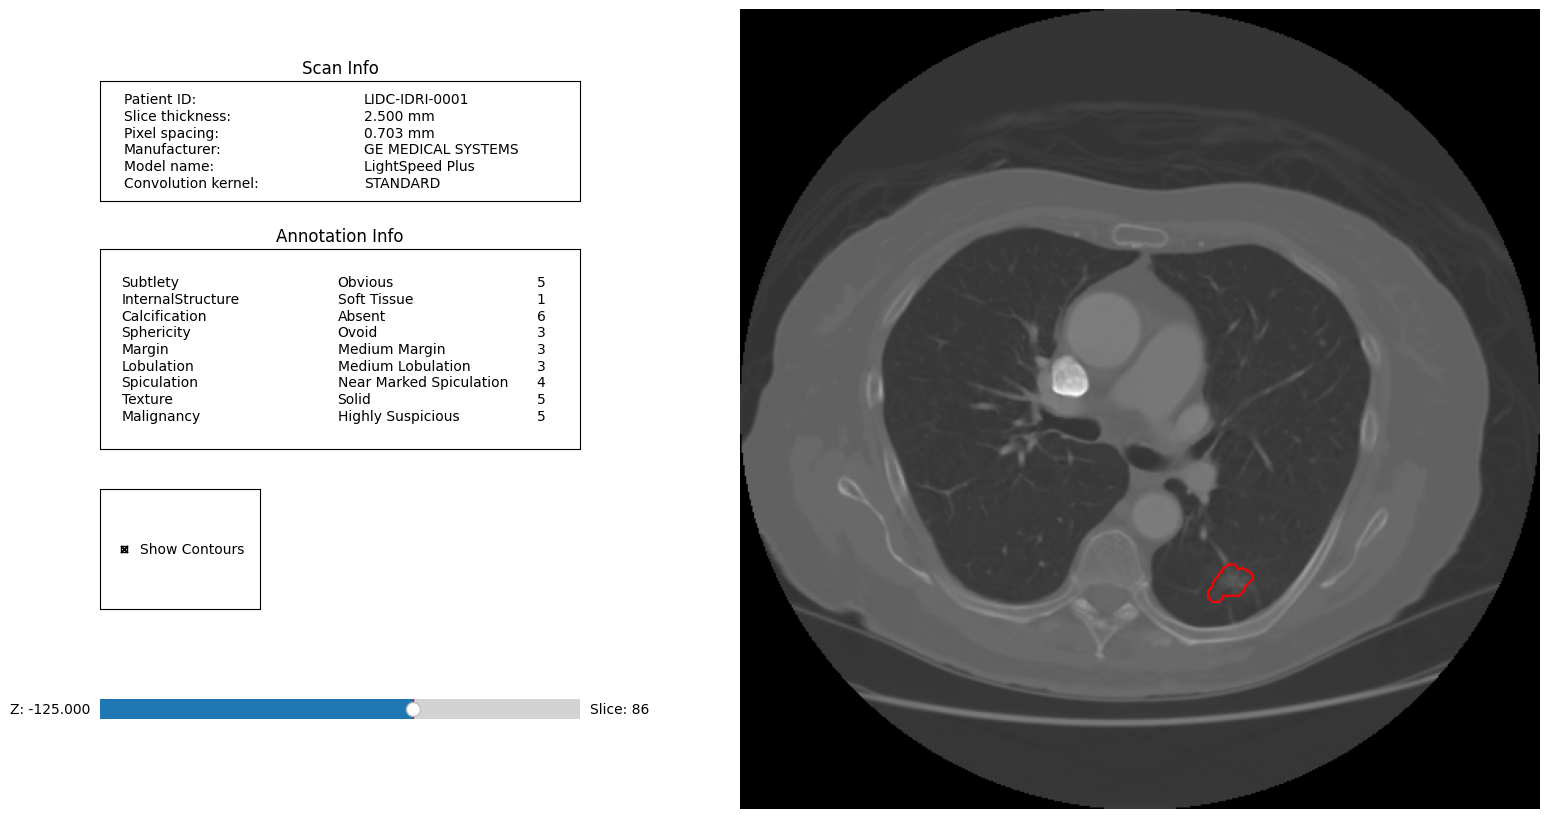

In [12]:
# Visualize the CT Scan
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


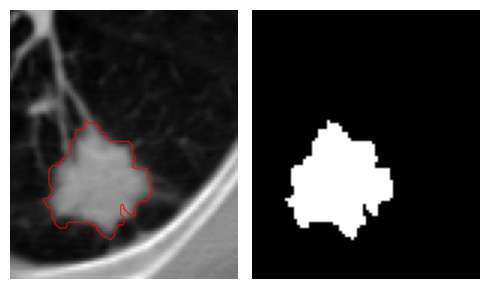

In [13]:
# Plot the Nodule's Mask
ann.visualize_nodule_mask()

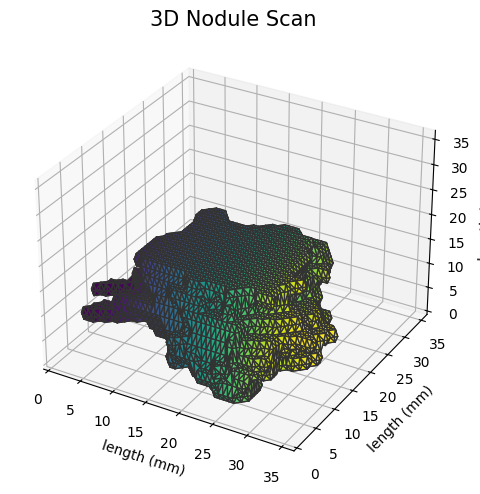

In [14]:
# Plot the Nodule 3D Scan
ann.visualize_in_3d()

---
### [PyLIDC] Features Dataset
---

The ``pylidc`` Python package is an essential tool for working with the LIDC-IDRI lung CT scan dataset, providing streamlined access to DICOM files, radiologist-drawn nodule contours, and subjective ratings such as malignancy. It facilitates **querying specific nodules** based on various attributes and also ``constructing consensus`` on the nodule volumes through **multiple radiologists’ annotations**. 

This package supports a wide range of applications, including medical **imaging research**, **radiomics analysis**, and the **development or evaluation of machine learning models** for ``lung nodule detection and characterization``.

---
#### [PyLIDC] Feature Extraction
---

After reviewing and reconsidering the **Nodule Attributes** in the [Pylidc package documentation](https://pylidc.github.io/) (as also summarized in the [README.md](./customPylidc/README.md) file within our **customPylidc package**), we selected those which we believe could ``contribute most significantly to predicting nodule malignancy``. Consequently, we created a simple framework for dataset creation, which we populated by **querying the data** from the aforementioned package.

During the **feature extraction process**, considering the data distribution outlined within the package, we implemented an ``automated consensus mechanism`` for nodule classification, as **multiple doctors** might have provided **varying diagnoses**. For **each patient’s nodule**, a weighted consensus was applied by taking into account **all annotations** made by the radiologists. For these annotations, we calculated the **mean for continuous (float) values** and used the **mode for categorical (already encoded integer) values** provided by the package.

Additionally, to **simplify the pipeline**, we chose to include only ``one scan per patient``, as there were only **eight patients** (out of 1012 patients) with **two scans** each. This decision was made because **multiple scans are likely correlated**, which would drastically **impact the consensus-building process**. Since our goal is to create a dataset with a **single entry per each nodule for every patient** [Represented as **<\"Patient_ID\-Nodule_ID">**], merging data from multiple scans would require a more **extensive analysis** of the overall data distribution which **would not significantly improve the quality of our dataset**.

In [15]:
# If the results have yet to be extracted (The .csv file with the pylidc features does not exist)
if not os.path.exists(config['pylidcFeaturesFilename']):
    df_pylidc = extractPylidcFeatures(config['pylidcFeaturesFilename'])
else:
    df_pylidc = pd.read_csv(config['pylidcFeaturesFilename'])

In [16]:
# Get some information regarding the dataset
df_pylidc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nodule_id          2617 non-null   object 
 1   slice_thickness    2617 non-null   float64
 2   pixel_spacing      2617 non-null   float64
 3   slice_spacing      2617 non-null   float64
 4   subtlety           2617 non-null   int64  
 5   internalStructure  2617 non-null   int64  
 6   calcification      2617 non-null   int64  
 7   sphericity         2617 non-null   int64  
 8   margin             2617 non-null   int64  
 9   lobulation         2617 non-null   int64  
 10  spiculation        2617 non-null   int64  
 11  texture            2617 non-null   int64  
 12  diameter           2617 non-null   float64
 13  surface_area       2617 non-null   float64
 14  volume             2617 non-null   float64
 15  malignancy         2617 non-null   int64  
dtypes: float64(6), int64(9),

In [17]:
# Check the dataframe dimensions
(rows, cols) = df_pylidc.shape
print(f"The pylidc feature dataset contains {rows} rows and {cols} cols")

The pylidc feature dataset contains 2617 rows and 16 cols


In [18]:
# Inspect the new dataset
df_pylidc.head(3)

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,diameter,surface_area,volume,malignancy
0,LIDC-IDRI-0001-1,2.50,0.703125,2.50,5,1,6,3,4,3,5,5,32.755812,2491.466573,6989.673615,5
1,LIDC-IDRI-0002-1,1.25,0.681641,1.25,2,1,6,5,1,1,1,1,30.781671,2807.198994,7244.667508,5
2,LIDC-IDRI-0003-1,2.50,0.820312,2.50,5,1,6,4,3,2,2,4,31.134465,2179.792304,6161.853145,5


---
#### [PyLIDC] Feature Analysis and Processing
---

In this subsection, we aim to conduct an ``exploratory data analysis`` on the ``PyLIDC dataset`` to gain deeper insights into how we can effectively **clean and manage** the available data.

We began by analyzing the **nodule subtlety distribution**, moving our way into the **distribution of malignancy [Target Class]** within the dataset population.

---
#### Subtlty Distribution Analysis
---
We started by analyzing the distribution of ``Subtlety``, which represents the **evel of difficulty in identifying nodules** where higher values indicate easier and more obvious nodules to detect, while lower values correspond to nodules which are extremely subtle and harder to recognize.

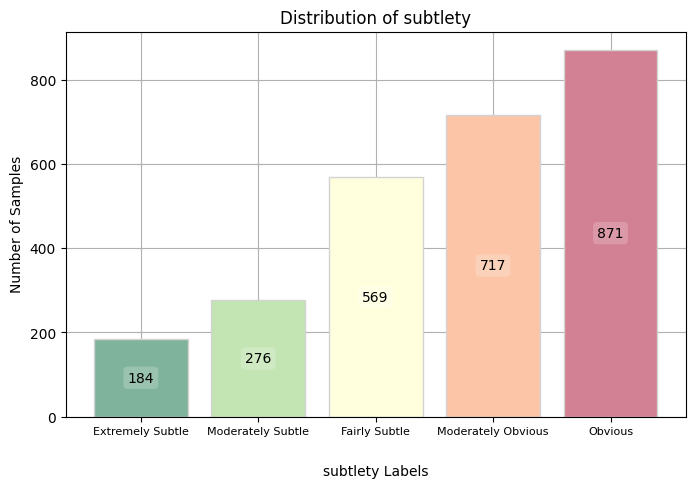

In [19]:
# Defining the subtlety decoder
subtletyDecoder = {
    1:"Extremely Subtle",
    2:"Moderately Subtle",
    3:"Fairly Subtle",
    4:"Moderately Obvious",
    5:"Obvious"
}

# Plot Subtlety class distribution
plotFeatureDistribution(df_pylidc, 'subtlety', True, subtletyDecoder)

From the bar plot, we can see that the distribution **leans toward the higher end of the subtlety scale**, with a greater number of samples in the **higher subtlety categories** (4 and 5). This indicates that the **majority of nodules in the dataset are relatively easy to detect**, while fewer nodules are subtle or harder to identify. As a result, this ``imbalance`` could affect machine learning models, potentially biasing them towards detecting the more obvious nodules due to their **higher prevalence** in the dataset.

---
#### Internal Structure Distribution Analysis
---

The ``Internal Structure`` of the nodules describes their **perceived internal composition**, such as whether they consist of soft tissue, fluid, or are simply composed of fat mass.

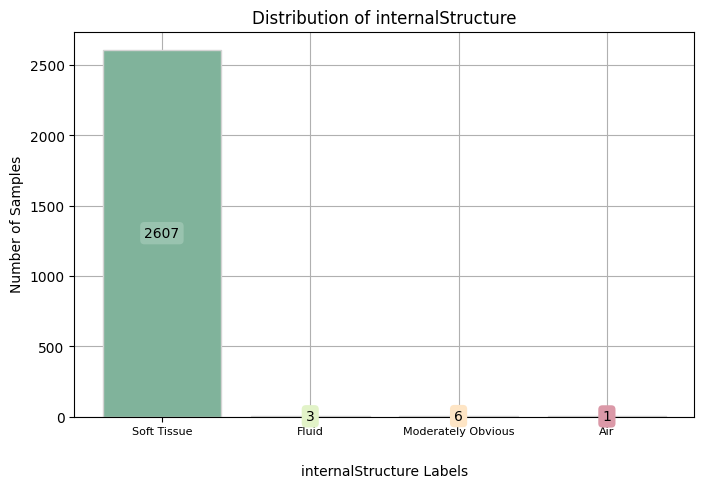

In [20]:
# Defining the Internal Structure Decoder
internalStructureDecoder = {
    1:"Soft Tissue",
    2:"Fluid",
    3:"Fat",
    4:"Moderately Obvious",
    5:"Air"
}

# Plot Internal Structure feature distribution
plotFeatureDistribution(df_pylidc, 'internalStructure', True, internalStructureDecoder)

As observed, the majority of nodules are **predominantly composed of soft tissue**, which is expected given that most carcinomas tend to have a **more solid structure**. This aligns with the biological nature of many cancerous growths, as they often **form dense, solid masses** due to abnormal cell proliferation.

---
#### Calcification Distribution Analysis
---

``Calcification`` refers to the **accumulation of calcium deposits** within nodule tissue, which appear as hardened areas on CT scans or X-rays and can vary in shape, size, and pattern. **Benign nodules** often exhibit **regular**, **well-defined** calcification patterns, such as 'popcorn' calcifications. 

In contrast, **malignant nodules** are **less likely to contain calcifications**. However, the ``absence of calcification does not necessarily indicate malignancy``, as **further analysis** of other nodule characteristics would be required to make a **definitive diagnosis**.

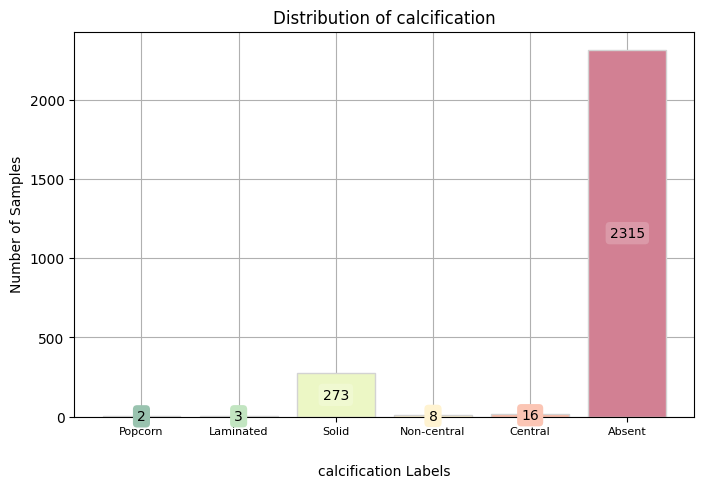

In [21]:
# Defining the Calcification Decoder
calcificationDecoder = {
    1:"Popcorn",
    2:"Laminated",
    3:"Solid",
    4:"Non-central",
    5:"Central",
    6:"Absent"
}

# Plot Calcification class distribution
plotFeatureDistribution(df_pylidc, 'calcification', True, calcificationDecoder)

The **majority of samples** (2315) show no calcification, indicating that most nodules **lack visible calcium deposits**. However, the absence of calcification alone is ``not a strong indicator`` of malignancy and therefore, should be **considered alongside other nodular characteristics** during analysis.

---
#### Margin Distribution Analysis
---

The ``Margin`` refers to **how clearly defined a nodule's edges are**. On one hand, a **poorly** defined nodule has **blurred or indistinct contours**, making its boundaries **less reliable**. On the other hand, a nodule with **sharp**, well-defined margins offers **precise**, almost surgical-level clarity, which aids in **more accurate assessments**.

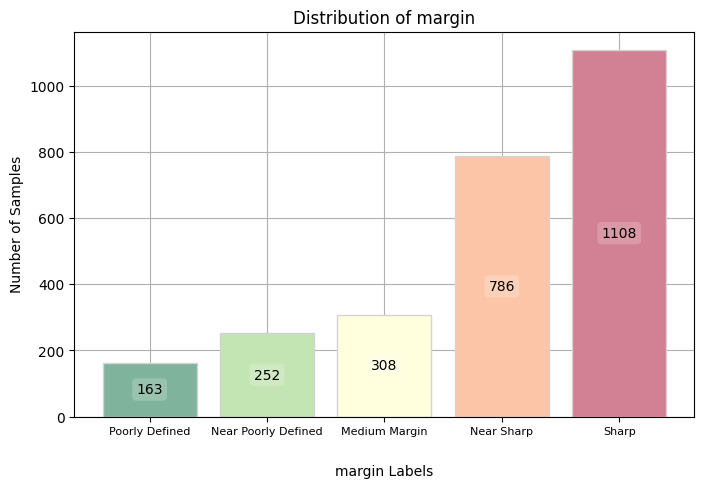

In [22]:
# Defining the Margin Decoder
marginDecoder = {
    1:"Poorly Defined",
    2:"Near Poorly Defined",
    3:"Medium Margin",
    4:"Near Sharp",
    5:"Sharp",
}

# Plot Margin feature distribution
plotFeatureDistribution(df_pylidc, 'margin', True, marginDecoder)

Since most nodules tend to have **well-defined margins**, their **precise contours** can be more easily identified. This level of detail **enhances the quality of the data**, enabling **more accurate diagnoses**.

---
#### Lobulation Distribution Analysis
---

``Lobulation`` consists on the **presence of lobes** or **rounded bumps** on the surface of a nodule. Nodules with these lobulated contours often have irregular, lobe-like extensions, which can point to **abnormal growth** and might **suggest malignancy**. On the other hand, nodules with **smooth**, **well-defined edges** are more commonly associated with **benign conditions**, though this ``isn’t always a guarantee``.

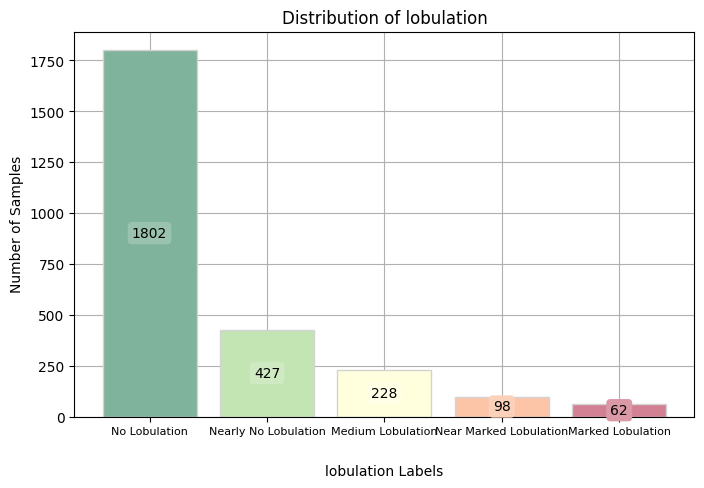

In [23]:
# Defining the Lobulation Decoder
lobulationDecoder = {
    1:"No Lobulation",
    2:"Nearly No Lobulation",
    3:"Medium Lobulation",
    4:"Near Marked Lobulation",
    5:"Marked Lobulation"
}

# Plot Lobulation feature distribution
plotFeatureDistribution(df_pylidc, 'lobulation', True, lobulationDecoder)

The majority of samples (1802) are categorized as having ``No Lobulation``, meaning most nodules have **smooth, well-defined edges** without lobes, which is typically indicative of **benign features**.

---
#### Malignancy Distribution Analysis
---

Finally, nodular ``malignancy`` helps differentiate between **benign and malignant nodules**, using a scale that ranges from 'Highly Unlikely' to 'Highly Suspicious'.

In [24]:
# Define a target label decoder
multiClassTargetDecoder = {
    1:'Highly Unlikely',
    2:'Moderately Unlikely',
    3:'Indeterminate',
    4:'Moderately Suspicious',
    5:'Highly Suspicious'
}

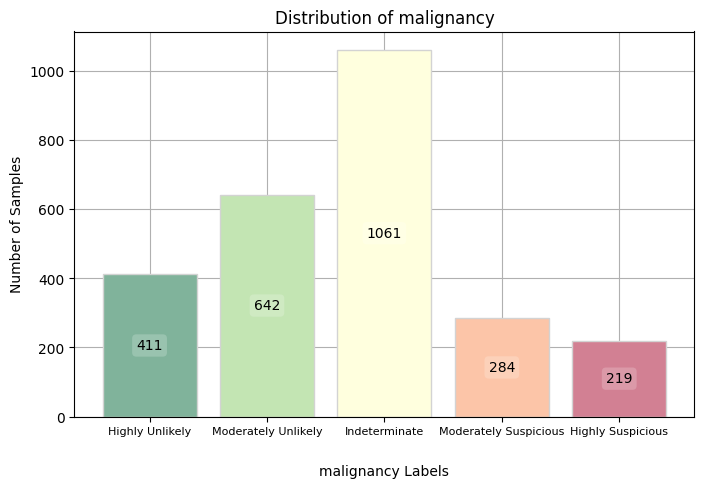

In [25]:
# Plot Malignancy target class distribution
plotFeatureDistribution(df_pylidc, 'malignancy', True, multiClassTargetDecoder)

As we can observe, most cases fall between the categories of **highly unlikely** and **indeterminate malignancy**, which aligns with the **earlier analysis** of the nodular characteristics within the dataset.

---
#### [PyLIDC] Target Class Processing
---

As we can observe from the ``Distribution of Malignancy`` on the Population, there are two main approaches:

<td>&nbsp;&nbsp;&rightarrow; <b>Multi-Class Classification</b>
    <dd>We can <b>utilize all the extracted information</b> to address a multi-class classification problem.</dd> 
</td> 
<td>&nbsp;&nbsp;&rightarrow; <b>Binary Classification</b>
    <dd>Given the complexity of the multi-label target feature, we can <b>adapt the data</b> (trough <b>Target Label Binarization</b>) to transform the problem into a binary classification task.</dd>
</td>

---
#### &rarr; Multi-Class Classification
---

Given that the dataset already contains **5 distinct labels** to assess the **malignancy of lung nodules**, we can utilize it as is, without altering the target class structure, which makes ``multi-class classification`` a suitable approach.

In [26]:
# Check if the multi-class dataset has already been computed (Is the same as the original pylidc_features.csv)
if not os.path.exists(config['multiClassPylidcFeaturesFilename']):
    # Save the dataset to later perform Multi-Class Classification
    df_pylidc.to_csv(config['multiClassPylidcFeaturesFilename'], sep=',', index=False)

However, since our ``primary goal`` is to **distinguish malignant nodules from non-malignant** ones, we chose to use a ``binary classification`` approach.

---
#### &rarr; Binary Classification [Target Label Binarization]
---

Since the data from the **PyLIDC framework** reflects the ``medical evaluation of nodules by doctors``, we determined that it would be more appropriate to analyze the **distribution of nodular malignancy** — and **potentially perform target re-labeling** — using the information **already present** in the dataset, even though **additional features will be introduced** later during the feature engineering process.

To ``reduce the number of labels`` within the target class, we can either **remove** or **modify the target labels** for entries with a **malignancy level of 3** (which indicates an indeterminate level of nodular malignancy). Moreover, we can **group labels 1 and 2 together**, as well as **labels 4 and 5**, effectively converting the task into a **binary classification problem**. 

Additionally, we also considered **classifying all indeterminate cases as malignant**, given that the primary objective is to **accurately identify the minority class** — malignant nodules. This approach prioritizes patient safety by erring on the side of caution, since it is preferable to **flag a nodule as malignant and later discover it is benign than to incorrectly classify a malignant nodule as benign**, which could have serious implications for the patient's diagnosis and treatment.

To address the **indeterminate cases**, one approach is to use ``K-Means clustering``. We can train the model on the non-indeterminate cases and then **predict to which clusters the indeterminate nodules belong to**, assigning them to a **specific class** rather than leaving them under a neutral label.

Another option was to use a ``Naive Bayes classifier`` to estimate the **probability of each indeterminate nodule belonging to one of the existing classes**, and **update its target label** based on the model's **prediction**. Although we implemented this approach, we ultimately decided **not to include it** in the project.

#### &rarr; [Indeterminate Cases] Removal

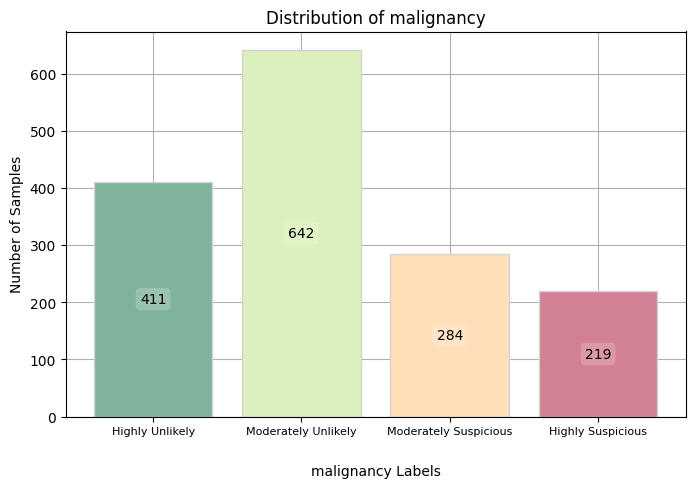

In [27]:
# Remove neutral cases from the dataset
df_remove = processIndeterminateNodules(df_pylidc, "remove")

# Plot the updated target feature distribution
plotFeatureDistribution(df_remove, 'malignancy', True, multiClassTargetDecoder)

As we can see, removing the indeterminate cases would **discard nearly half of the data**, and given that we're not working with a large dataset, it's preferable to ``reassign those values`` into the remaining classes instead."

#### &rarr; [Indeterminate Cases] Move To Malignant

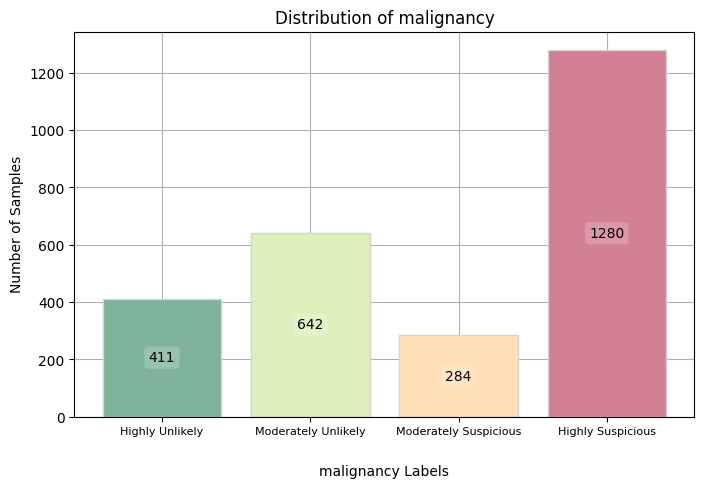

In [28]:
# Move neutral cases to a Highly Suspicious
df_moveToMalignant = processIndeterminateNodules(df_pylidc, "moveToMalignant")

# Plot the updated target feature distribution
plotFeatureDistribution(df_moveToMalignant, 'malignancy', True, multiClassTargetDecoder)

Although this approach aims to minimize mispredictions, it results in a sample that **does not accurately represent the population**, as this could be problematic in real-world scenarios, since it may lead to **unnecessary costs** for hospitals if a significant number of patients are **incorrectly diagnosed with cancer**.

#### &rarr; [Indeterminate Cases] K-Means

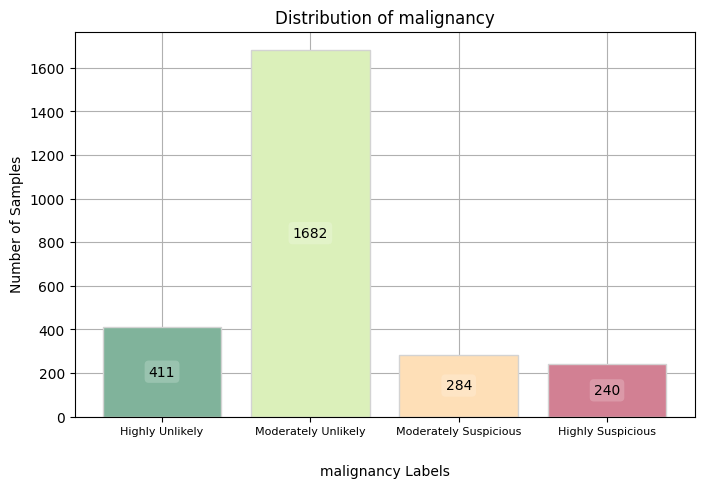

In [29]:
# Process indeterminate Nodules using the K-Means algorithm
df_kmeans = processIndeterminateNodules(df_pylidc, "kmeans")

# Plot the updated target feature distribution
plotFeatureDistribution(df_kmeans, 'malignancy', True, multiClassTargetDecoder)

By training a **clustering algorithm (K-Means)** on the non-indeterminate nodules and then **re-labeling** the indeterminate nodules based on the **model's predictions**, we were able to **maintain reasonable class proportions**, while providing a **good approximation of the overall population without discarding large amounts of data**. Consequently, we are left to **group the remained labels** as previously mentioned.

In [30]:
# Perform Binarization
df_binary_pylidc = binarizeTargetLabel(df_pylidc, "kmeans", config['binaryPylidcFeaturesFilename'])

In [31]:
# Create a target decoder to visualize the binary target labels
binaryTargetDecoder = {
    0:'Highly Unlikely',
    1:'Highly Suspicious'
}

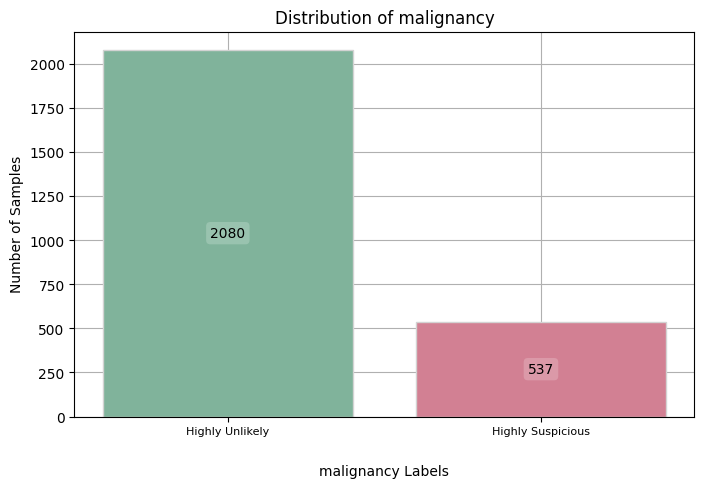

In [32]:
# Plot the updated target feature distribution
plotFeatureDistribution(df_binary_pylidc, 'malignancy', True, binaryTargetDecoder)

As seen in the previous plot depicting the malignancy of the nodules in the dataset, there is a ``clear imbalance between the two classes``. This is an issue **we will address later** in the model development phase by using sampling techniques to mitigate this disproportionality.

<div align="center">

---
## Feature Engineering
---
</div>

In this project, the primary goal of ``feature engineering`` is to enrich the dataset by incorporating quantitative features that enhance the distinction between benign and malignant nodules. These features will play a critical role in developing more accurate models capable of detecting subtle patterns and complex relationships within the imaging data. By doing so, we aim to **significantly improve diagnostic precision**, leading to **better predictive performance** and ultimately contributing to **more informed clinical decision-making and improved patient outcomes**.

---
### [Pyradiomics] Features Dataset
---

The ``pyradiomics`` Python package is a versatile tool designed for extracting quantitative **radiomic features from medical images**, providing a robust framework for imaging analysis in research and clinical contexts. It supports a wide array of feature types, including first-order statistics, shape-based metrics, and texture features derived from advanced matrices like GLCM and GLSZM, and allows for **multi-scale analysis** through wavelet filters. With support for multiple imaging modalities and file formats, and integration with **segmentation tools** to target regions of interest (ROIs), pyradiomics offers extensive customizability and the ability to **define custom workflows** and feature sets, making it suitable for a variety of research applications.

In contrast to pylidc, which focuses on lung CT data and radiologist annotations within the LIDC-IDRI dataset, pyradiomics provides a **more comprehensive feature extraction framework** that is not limited to specific datasets or anatomical regions. While pylidc is centered on managing and visualizing nodule annotations, **pyradiomics facilitates detailed quantitative analysis**, making it a valuable tool for radiomics research and the development of predictive models based on medical imaging data.

---
#### [Pyradiomics] Feature Extraction
---

By utilizing the pyradiomics library, our goal is to **expand the feature set** in our dataset to achieve more accurate results, ultimately leading to a **more precise assessment** of the malignancy of the patient's nodules.

We began by analyzing the structure of the LIDC-IDRI dataset, which is organized across **multiple nested folders**, to locate the relevant files. After understanding the directory layout, we **adapted a script and configuration file** from the pyradiomics GitHub repository. This allowed us to create a new script capable of efficiently **extracting the majority of the available data related to the patient's nodules**.

For the configurations, we chose to extract **3D features** because this approach captures the **full volumetric information of the nodules**, ensuring a more detailed analysis of their shape and texture. By accounting for the spatial relationships between slices, 3D extraction provides a more **comprehensive and reliable representation of the nodule's structure**, which is critical for accurately assessing malignancy.

After generating the new dataset with these features, we aimed to **clean and refactor it**, organizing each entry to represent a patient's nodule for further analysis.

In [33]:
# Variable to determine if we perform feature extration using the pyradiomics package
extractPyradiomicsFeatures = False

# Perform Pyradiomics Feature Extraction
if extractPyradiomicsFeatures:
    files_path = 'c:\\Insert\\Global\\Path\\To\\LIDC-IDRI'
    extractPyradiomicsFeatures(Lidc_IdrFilesPath=files_path,
                               pyradiomicsDcmScriptPath='./pyradiomics-dcm.py',
                               pyradiomicsParamsFilePath='./Pyradiomics_Params.yaml',
                               pyradiomicsFeatureDictFilePath='./featuresDict.tsv',
                               startPatient=0,
                               outputDirectoryPath='./OutputSR',
                               tempDirectoryPath='./TempDir')
# Load the dataset
else:
    df_pyradiomics = pd.read_csv(config['pyradiomicsFeaturesFilename'], index_col=False)

In [34]:
# Get some information regarding the dataset
df_pyradiomics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Columns: 1599 entries, annotation_id to logarithm_ngtdm_Strength
dtypes: float64(1565), int64(4), object(30)
memory usage: 57.2+ MB


In [35]:
# Check the dataframe dimensions
(rows, cols) = df_pyradiomics.shape
print(f"The pyradiomics feature dataset contains {rows} rows and {cols} cols")

The pyradiomics feature dataset contains 4688 rows and 1599 cols


In [36]:
# Inspect the first rows from the dataset
df_pyradiomics.head(3)

,annotation_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001-2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001-3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214


---
#### [Pyradiomics] Feature Cleaning and Processing
---

By cleaning the pyradiomics dataset, we aim to **improve the quality and consistency of the data**. The **removal of noise**, **correcting errors**, and **eliminating irrelevant features**, which helps us ensure that each entry accurately represents a patient's nodule and therefore **simplifying the data for analysis**, leading to more reliable machine learning models.

In [37]:
# Split the 'annotation_id' column into 'patient_id' and 'nodule_id'
df_pyradiomics[['patient_id', 'ann_id']] = df_pyradiomics['annotation_id'].str.rsplit('-', n=1, expand=True)

# Reorder the columns to move 'patient_id' and 'nodule_id' to the beginning
cols = ['patient_id', 'ann_id'] + [col for col in df_pyradiomics.columns if col not in ['patient_id', 'ann_id']]

# Drop 'annotation_id' and reorder the DataFrame
df_pyradiomics = df_pyradiomics[cols]

# Remove the annotation id column
df_pyradiomics = df_pyradiomics.drop(columns=['annotation_id'], axis=1)

In [38]:
df_pyradiomics.iloc[:, 143:] = df_pyradiomics.iloc[:, 143:].apply(lambda x: x.shift(273) if x.isna().any() else x, axis=1)

# Drop rows with NaN Values
df_pyradiomics = df_pyradiomics.dropna(how='any')

df_pyradiomics.head(3)

,patient_id,ann_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001,2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001,3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214


In [39]:
# Check if is has already been created
if not os.path.exists(config['pyradiomicsRefactoredFeaturesFilename']):
    df_refactored_pyradiomics = refactorPyradiomicsDataset(df_pyradiomics, config['pyradiomicsRefactoredFeaturesFilename'], verbose=False)

# Load the refactored dataset
else:
     df_refactored_pyradiomics = pd.read_csv(config['pyradiomicsRefactoredFeaturesFilename'], index_col=False)

In [40]:
# Inspect the new refactored dataframe
df_refactored_pyradiomics.head(3)

,nodule_id,patient_id,ann_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,LIDC-IDRI-0001,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,0.125483,0.020089,0.454728,708.128969,0.009230,0.123915,0.002229,35948.350251,6.665276,14.423402
1,LIDC-IDRI-0002-1,LIDC-IDRI-0002,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,104.713631,0.517346,0.083483,76.432466,0.012528,1.814987,0.007012,1896.840261,0.618637,52.197389
2,LIDC-IDRI-0003-1,LIDC-IDRI-0003,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,209.395329,0.693513,0.032239,1.005262,0.008692,13.673589,0.009964,15.072607,0.017851,4.623489


We then, examined the **different data types** within the dataset and **reviewed sample values** from each feature. This allowed us to better understand the **significance of each feature**, how they are formatted, and how we could further **enhance their representation** within the dataset.

In [41]:
# Get the dtypes from the features
colsTypes = np.unique(list(df_refactored_pyradiomics.dtypes))
print(f"The pyradiomics dataset is composed of features with the following dtypes: \n")
[print(f"-> {col}") for col in colsTypes]
print()

The pyradiomics dataset is composed of features with the following dtypes: 

-> int64
-> float64
-> object



Most of the data types are already correctly formatted as int64 and float64. However, we need to **closely inspect the object type features**, as they may either contain valuable information or add noise to the dataset. Therefore, these features should be **carefully selected** and processed based on their content and structure.

In [42]:
# Get a dataframe with all the object type features
df_object_features = df_refactored_pyradiomics.select_dtypes(include=['object'])

In [43]:
# Check the data inside each object feature
for column in df_object_features.columns:
    print(f"[{column}] -> {df_object_features[column][0]}\n")

[nodule_id] -> LIDC-IDRI-0001-1

[patient_id] -> LIDC-IDRI-0001

[diagnostics_Versions_PyRadiomics] -> v3.1.0

[diagnostics_Versions_Numpy] -> 1.24.3

[diagnostics_Versions_SimpleITK] -> 2.4.0

[diagnostics_Versions_PyWavelet] -> 1.6.0

[diagnostics_Versions_Python] -> 3.9.0

[diagnostics_Configuration_Settings] -> {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': [2, 2, 2], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 10, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'voxelArrayShift': 1000, 'geometryTolerance': 1e-06, 'correctMask': False}

[diagnostics_Configuration_EnabledImageTypes] -> {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3.0]}, 'Wavelet': {}, 'Gradient': {}, 'Square': {}, 'SquareRoot': {}, 'Exponential': {}, 'Logarithm': {}}

[diagnostics_Image-original_Hash] -> 536a24a547656

<br/>
As we can observe, there are <b>several irrelevant features</b> (such as 'patient_id', and version or hash-related features) that should be removed.
<br/>
<br/>
Additionally, there are <b>features containing 3D information</b> (such as 'diagnostics_Image-interpolated_Size') that should be <b>split into separate columns<b>. This will simplify the model’s learning process during training, making it easier to interpret and utilize the data.
<br/>
<br/>

In [44]:
# Fetching useless features from the pyradiomics dataset to later removed them
columnsToRemove = ['patient_id', 'ann_id', 'diagnostics_Image-original_Dimensionality'] + \
                  [column for column in df_object_features.columns if 'Hash' in column or 'Versions' in column or str(df_object_features[column][0])[0] == '{'] + \
                  [column for column in df_refactored_pyradiomics.columns if 'Num' in column]

In [45]:
try:
    # Drop the columns selected
    df_refactored_pyradiomics = df_refactored_pyradiomics.drop(columns=columnsToRemove, axis=1)
except:
    print("The selected columns have already been removed!")

# Update the Dataframe of the object features
df_object_features = df_refactored_pyradiomics.select_dtypes(include=['object'])

In [46]:
# Fetch the features whoose string data is composed by tuples
tupleColumns = [column for column in df_object_features.columns if df_object_features[column][0][0] == '(']

In [47]:
# Parse strings with tuple format inside the pyradiomics dataset
try:
    df_refactored_pyradiomics = mapTuplesInsideDataframe(df_refactored_pyradiomics, tupleColumns, verbose=False)
except:
    print(f"The String like Tuple features have already been processed.\n")

df_refactored_pyradiomics.head(3)

,nodule_id,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_Mean,diagnostics_Mask-interpolated_Minimum,diagnostics_Mask-interpolated_Maximum,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,-826.943929,-2048.0,3071.0,-412.472265,-988.332443,1016.145157,-78.624550,-830.888565,233.304367,...,0.0,13.0,16.0,10.0,16.612761,19.668867,4.528053,55.873960,86.286171,-116.193894
1,LIDC-IDRI-0002-1,-826.943929,-2048.0,3071.0,-564.912672,-1013.177460,1022.079742,-797.314835,-983.115417,154.665916,...,0.0,15.0,10.0,17.0,17.457944,16.253672,8.120160,60.075067,72.666523,-104.134680
2,LIDC-IDRI-0003-1,-826.943929,-2048.0,3071.0,-563.521360,-982.593091,946.504822,-856.918832,-962.924475,-349.836878,...,0.0,13.0,14.0,10.0,18.128906,16.902344,5.667969,74.047656,74.394531,-212.914062


---
### Final Features Dataset
---

After constructing the **previous datasets**, the next step is to **merge them** based on the ``nodule_id`` feature to create a **more comprehensive and robust dataset**. Following that, we will perform **additional data processing steps**, including **normalization**, **handling class imbalance**, and **addressing the issue of high dimensionality**, as the dataset contains a large number of features.

This final dataset will then be used to **train our models**, ultimately helping doctors **make more accurate clinical assessments** of the malignancy of patients' nodules.

In [48]:
# Merge both datasets on the nodule_id column
df_merged = pd.merge(df_binary_pylidc, df_refactored_pyradiomics, on='nodule_id')
df_merged.head(3)

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,2.50,0.703125,2.50,5,1,6,3,4,3,...,0.0,13.0,16.0,10.0,16.612761,19.668867,4.528053,55.873960,86.286171,-116.193894
1,LIDC-IDRI-0002-1,1.25,0.681641,1.25,2,1,6,5,1,1,...,0.0,15.0,10.0,17.0,17.457944,16.253672,8.120160,60.075067,72.666523,-104.134680
2,LIDC-IDRI-0003-1,2.50,0.820312,2.50,5,1,6,4,3,2,...,0.0,13.0,14.0,10.0,18.128906,16.902344,5.667969,74.047656,74.394531,-212.914062


In [49]:
# Remove rows with at least one null / NaN Value
df_merged = df_merged.dropna(how='any')

In [50]:
# Inspect the shape of the new dataset
(mergedRows, mergedCols) = df_merged.shape
print(f"The merged dataset contains {mergedRows} rows and {mergedCols} columns")

The merged dataset contains 1648 rows and 1634 columns


---
#### &rarr; Data Normalization
---

Since the features in the dataset have **varying ranges**, **those with larger scales can dominate the learning process**, causing the model to **assign them more importance**, even if they are less informative. Our goal is for each feature to **contribute equally** to the model's development.

Additionally, distance-based algorithms, like Support Vector Machines, can be **disproportionately affected by larger scales**, resulting in biased outcomes. Significant differences in feature scales can also cause **numerical issues during training**, such as when performing matrix inversions or dot product calculations.

Furthermore, gradient-based algorithms, like XGBoost, are **sensitive to input scales**, which can **slow down convergence** or even lead to **suboptimal solutions**.

To address these problems, we need to ``normalize the data``, while aiming to improve the integrity, reliability, and overall performance of our to-be developed machine learning models.

In this project, we chose to use the **Min-Max normalization** technique since it **scales all features to a specified range (typically between 0 and 1)**, ensuring that no feature dominates due to its scale. It also **maintains the relative distances between data points**, making it ideal for machine learning algorithms that are sensitive to the scale of input features, such as Support Vector Machines and gradient-based models like XGBoost. 

In [51]:
# Perform Min-Max Scaling for data normalization
df_normalized = performDataNormalization(df_merged, method='min-max')
df_normalized.head(3)

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,0.431818,0.469697,0.444444,5,1,6,3,4,3,...,0.0,0.6,0.714286,0.363636,0.736490,0.746699,0.266863,0.671376,0.872239,0.713049
1,LIDC-IDRI-0002-1,0.147727,0.428031,0.166667,2,1,6,5,1,1,...,0.0,0.7,0.428571,0.681818,0.784472,0.468571,0.508173,0.684370,0.825063,0.752704
2,LIDC-IDRI-0003-1,0.431818,0.696969,0.444444,5,1,6,4,3,2,...,0.0,0.6,0.619048,0.363636,0.822564,0.521398,0.343440,0.727584,0.831048,0.395000


---
#### &rarr; Highly Correlated Features
---

``Highly correlated features`` introduce redundancy, as they carry similar information, which can lead to issues such as multicollinearity, overfitting, and reduced model interpretability. Multicollinearity, for an example, can make it difficult for linear models to **distinguish the individual effects of correlated features**, resulting in **unstable and even unreliable estimates**.

Additionally, correlated features can **increase the complexity of the model** without providing additional value, slowing down training and making the model **more prone to overfitting**. 

Therefore, by **removing these redundant features**, we **simplify the model**, **reduce noise**, and **improve the generalization and efficiency** of our machine learning algorithms.

In [52]:
# Remove Highly correlated features
df_clean = removeHighlyCorrelatedFeatures(df_normalized)
df_clean.head(3)

,nodule_id,slice_thickness,pixel_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,...,diagnostics_Image-interpolated_Spacing_1,diagnostics_Image-interpolated_Spacing_2,diagnostics_Image-interpolated_Spacing_3,diagnostics_Image-interpolated_Size_3,diagnostics_Mask-interpolated_Spacing_1,diagnostics_Mask-interpolated_Spacing_2,diagnostics_Mask-interpolated_Spacing_3,diagnostics_Mask-interpolated_BoundingBox_1,diagnostics_Mask-interpolated_BoundingBox_2,diagnostics_Mask-interpolated_BoundingBox_3
0,LIDC-IDRI-0001-1,0.431818,0.469697,5,1,6,3,4,3,5,...,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.888889,0.666667,0.0
1,LIDC-IDRI-0002-1,0.147727,0.428031,2,1,6,5,1,1,1,...,0.0,0.0,0.0,0.7,0.0,0.0,0.0,0.888889,0.333333,0.0
2,LIDC-IDRI-0003-1,0.431818,0.696969,5,1,6,4,3,2,2,...,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.888889,0.333333,0.0


---
#### &rarr; [Potential] One-Hot Encoding
---

Through a deep analysis on the dataset, we can infer that it **does not contain any binary features**, and therefore **does not need** to be used upon a **One-Hot Encoding** Procedure

---
#### &rarr; Principal Component Analysis (PCA)
---
As the **number of features in a dataset increases**, the amount of data needed to achieve statistically significant results grows exponentially. This can lead to **issues** such as:

1. **Overfitting**
2. **Longer computation times**
3. **Reduced Accuracy** in machine learning models

> This challenge is known as the curse of dimensionality since we are working with high-dimensional data

To address it, we used ``Principal Component Analysis (PCA)``, a **dimensionality reduction technique** that helped us capture the **maximum variance in the data with fewer features**. PCA transforms the original variables into new variables, called **principal components**, which are **linear combinations of the original features** and are ranked by the amount of variance they explain.

By selecting the **most important principal components**, we reduced the number of features while retaining as much of the dataset's variance as possible. This trade-off **simplified the dataset**, making it easier to work with and improving the performance and efficiency of our machine learning models.

In [53]:
# Fetch the features of the dataframe to perform PCA
X_initial = df_clean.drop(columns=['nodule_id', 'malignancy'])

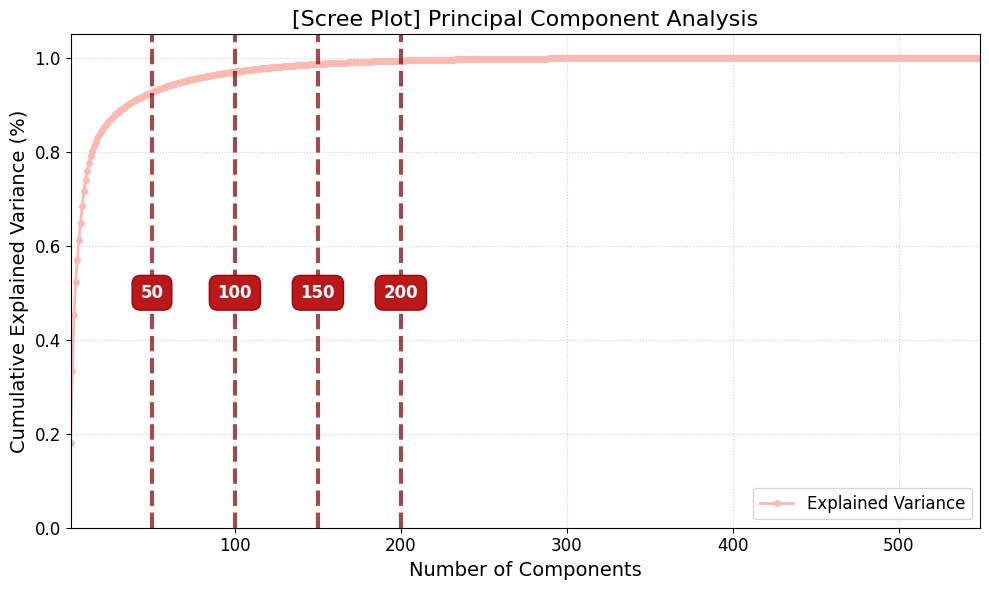

In [54]:
# Perform PCA with the maximum amount of components
(_, explainedVariance, pcValues) = computePCA(549, X_initial)
plotScreeGraph(pcValues, explainedVariance)

By analyzing the first graph, we can see that the **optimal number of components for PCA** is **between 100 and 200**, as this is where the cumulative variance starts to flatten out. This indicates that **using fewer components would result in loss of information**, while using more components **could risk overfitting**.

Let's analyse a second Scree Plot (more detailed) to **pinpoint exactly where the 'ideal' number of components for PCA is located**.

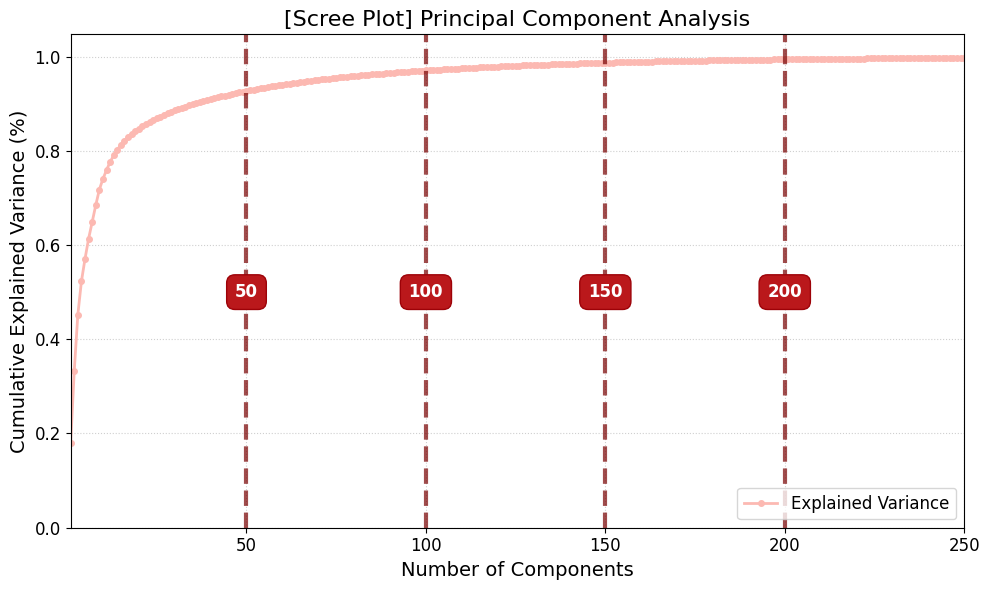

In [55]:
# Perform PCA with a reduced amount of components
(_, explainedVariance, pcValues) = computePCA(250, X_initial)
plotScreeGraph(pcValues, explainedVariance)

As we can see, the **optimal number** of principal components hovers around **150**, so we chose this value to mitigate the issue of dimensionality within the dataset.

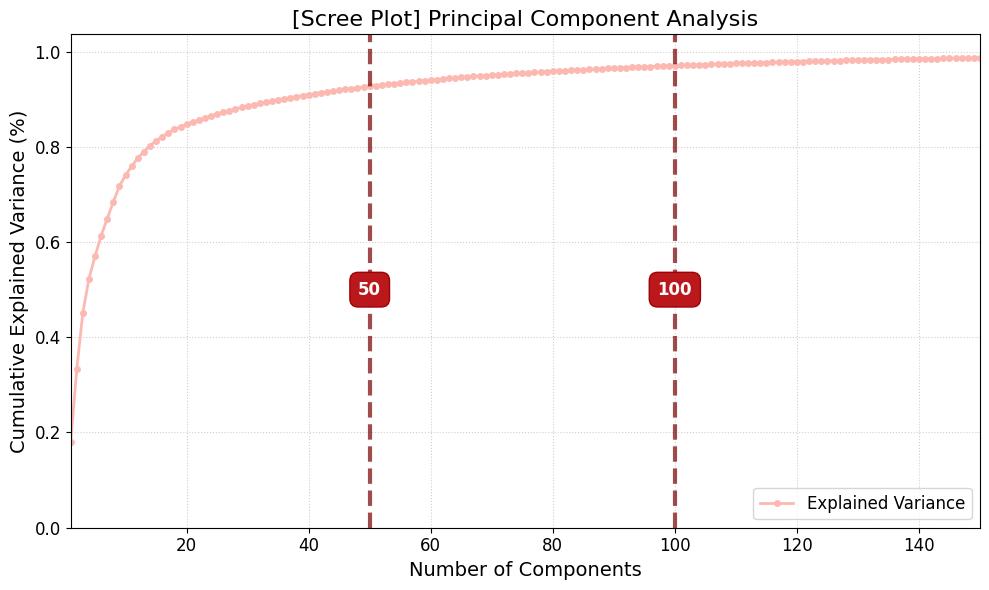

In [56]:
# Choosing 150 as the ideal number of components and updating the training dataset
(mostImportantFeatureIdxs, explainedVariance, pcValues) = computePCA(150, X_initial)
plotScreeGraph(pcValues, explainedVariance)

Finally, we need to **convert the most important features extracted from the PCA** and **update the dataset** to include only those features.

In [57]:
# Getting the most important features in the dataset
mostImportantFeatures = np.unique(['nodule_id'] + \
                                  [df_clean.columns[featureIdx] for featureIdx in mostImportantFeatureIdxs] + \
                                  ['malignancy'])

In [58]:
# Updating the dataframe with the most important features inside the dataset
df_final = df_clean[mostImportantFeatures]

In [59]:
# Inspect the shape of the final dataset
(finalRows, finalCols) = df_final.shape
print(f"The final dataset contains {finalRows} rows and {finalCols} columns")

The final dataset contains 1648 rows and 88 columns


In [60]:
# Save the Final Dataset
if not os.path.exists(config['finalFeaturesDatasetFilename']):
    df_final.to_csv(config['finalFeaturesDatasetFilename'], sep=',', index=False)

<div align="center">

---
## Model Development and Evaluation
---
</div>

In this section, we will **explore the class imbalance** issue in greater depth and outline the strategies employed to address it. Furthermore, we will detail **how the data was split into features and target** variables to support the development of machine learning models.

As previously mentioned, we will **select various machine learning algorithms** for training and evaluation, aiming to **assess their effectiveness** in helping doctors make informed decisions about the malignancy of patient nodules. To optimize model performance, we applied techniques such as **grid search** and **group-stratified K-fold cross-validation**, ensuring a more robust and reliable evaluation.

---
### Class Imbalance Assessment
---

Initially, let's start by taking a look on the **maligncy target class distribution**.

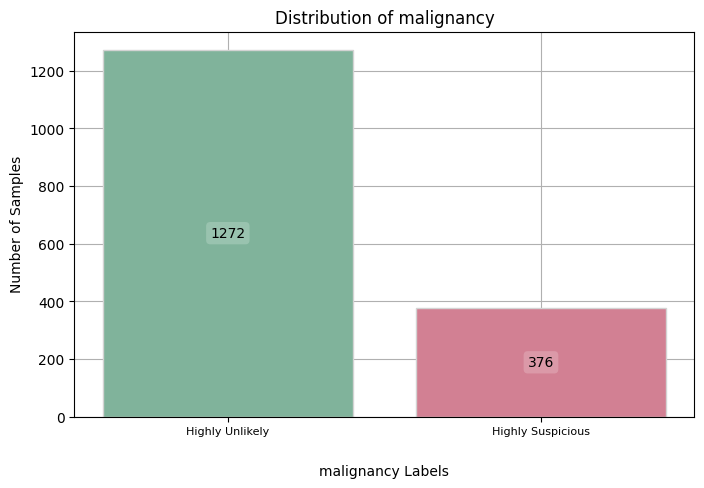

In [61]:
# Plot the target feature distribution
plotFeatureDistribution(df_final, 'malignancy', True, binaryTargetDecoder)

There are nearly four times more benign nodules than malignant ones in the dataset, which presents a **challenge** since most machine learning models struggle with **imbalanced data**. To address this, we considered several techniques, including:

1. ``Random Oversampling`` : This method **duplicates entries from the minority class** to balance the dataset. However, it can **lead to overfitting** since the same data points are reused multiple times.

2. ``Random Undersampling`` : This approach **removes instances from the majority class** to balance the classes. While effective with large datasets, it **risks discarding valuable information** when data is limited.

3. ``SMOTE`` (Synthetic Minority Oversampling Technique): SMOTE generates **synthetic data points for the minority class** by interpolating between nearby data points, **introducing variety** without exact duplication. This helps **avoid overfitting** while mitigating class imbalance.

After considering the available options, we decided to apply **SMOTE exclusively to the whole training set**, leaving the **test set unchanged** to maintain its real-world representation. Therefore, this approach focuses on class imbalance during model training while **avoiding the introduction of artificial bias** in the evaluation phase and providing a balanced variety of the data.

---
### Data Partitioning
---

We now need to prepare the data for model training. To do this, we selected the **relevant features from the dataset**, excluding the target variable (``malignancy``) and ``nodule_id``, which was used for identification during previous preprocessing steps. We then specified the **target variable**, which represents the nodular malignancy (``malignancy``).

In [62]:
# Split the data into features and target
X = df_final.drop(columns=['nodule_id', 'malignancy'])
y = df_final['malignancy']

In addition, we **split the data into 10 folds for cross-validation** (while performing SMOTE on the train set of each fold) to gain better insights into the model's performance. This fold segmentation accounts for the **groups within the dataset**, ensuring that **all nodules from the same patient are either in the training set or the test set**, but not both, to prevent biased predictions. Moreover, both sets are stratified, meaning they **maintain the same proportions of benign and malignant nodules**, ensuring **balanced representation** of the target classes. 

> This approach is known as Stratified Group K-Fold Cross Validation.

In [63]:
# Split the data across multiple folds while maintaining a class proportion between
# train and test sets as well as keeping each group in one of these sets
# (Keeping the nodules of each patient inside the same set)
folds = stratifiedGroupKFoldSplit(df_final, useSMOTE=True, n_splits=10)

---
### [Selection] Machine Learning Algorithms
---

For the **machine learning algorithms** we selected:

1. Support Vector Machine (SVM)
2. Random Forest
3. XGBoost

``SVM`` is well-suited for binary classification tasks like this one, as it **excels at finding the optimal decision boundary between classes**, even in high-dimensional spaces.

``Random Forest``, an ensemble method, provides **robust predictions by combining multiple decision trees**, which helps **reduce overfitting and increases generalization**. 

Finally, ``XGBoost``, a powerful gradient-boosting algorithm, was chosen for its **efficiency and ability to handle complex data relationships**, while also being **resistant to overfitting**. 

To sum up, these models were selected for their **proven effectiveness in classification tasks**, especially when dealing with **imbalanced datasets**, as is the case in our problem.

---
### [Development] Machine Learning Algorithms
---

We developed a comprehensive pipeline to optimize and evaluate each machine learning model. The process starts with a **grid search to identify the best parameters for the model**, ensuring an optimal configuration tailored to the dataset.

After selecting the best parameters and estimator, we apply **stratified group 10-fold cross-validation**. This ensures the model’s performance is evaluated while **preserving both patient groupings and the class balance** between benign and malignant nodules.

For evaluation, we **computed several key performance metrics** (stored in json files), including:

1. ``Accuracy``
2. ``Balanced Accuracy``
3. ``Recall``
4. ``F1-score``
5. ``Precision`` (Via Precision-Recall Curve)
6. ``AUC Score`` (Via ROC Curve)
7. ``Log loss``
8. ``Hamming Loss``

Additionally, we used **visual tools** like the ``precision-recall curve``, ``onfusion matrix`` and ``ROC curve`` to provide a thorough analysis of each model's performance.

---
#### Scoring Methodology
---

In our ``Grid Search``, we modified how the best parameters and estimator were selected by providing a **specific scoring metric for optimization**. A scoring metric **guides the Grid Search in determining the optimal solution**. We chose to use both **balanced accuracy** and **recall** for this purpose.

On one hand, ``balanced accuracy`` offers a **clearer understanding of model performance on imbalanced datasets**, ensuring that **both classes are fairly represented** in the evaluation. On the other hand, ``recall`` is particularly important in **minimizing the misclassification of malignant nodules as benign**, which is critical for improving patient outcomes and ensuring accurate diagnoses.

While we also calculated results using the **default scoring of accuracy**, we opted not to include them in the final analysis, as **balanced accuracy offers more meaningful insights** inside the current setting.

---
#### SVM
---


#### &rarr; SVM [Balanced Accuracy Scoring]

In [64]:
# Define the scoring method
scoring = 'balanced_accuracy'

In [65]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['SVC'][scoring]['bestParamsPath']):
    # Compute the best parameters
    svmBestParams = computeModelBestParameters(SVC, modelParameterGrids, X, y, scoring, modelPaths, True)
else:
    # Load already computed parameters
    svmBestParams = jsonFileToDict(modelPaths['SVC'][scoring]['bestParamsPath'])

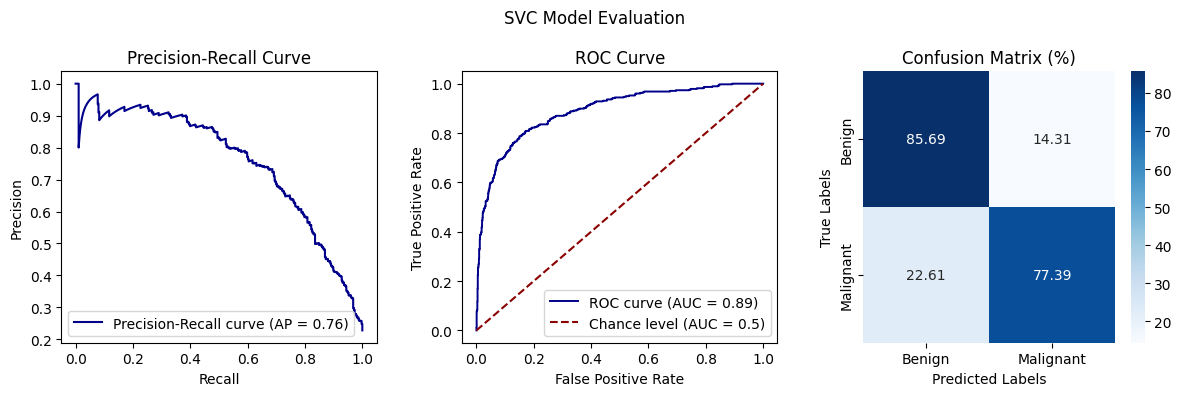

In [66]:
# Calculate and Plot some metrics associated with the SVM
svmMetricsBalancedAccuracy = evaluateModel(SVC, scoring, folds, modelPaths, ['Benign', 'Malignant'])

#### &rarr; SVM [Recall Scoring]

In [67]:
# Define the scoring method
scoring = 'recall'

In [68]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['SVC'][scoring]['bestParamsPath']):
    # Compute the best parameters
    svmBestParams = computeModelBestParameters(SVC, modelParameterGrids, X, y, scoring, modelPaths, True)
else:
    # Load already computed parameters
    svmBestParams = jsonFileToDict(modelPaths['SVC'][scoring]['bestParamsPath'])

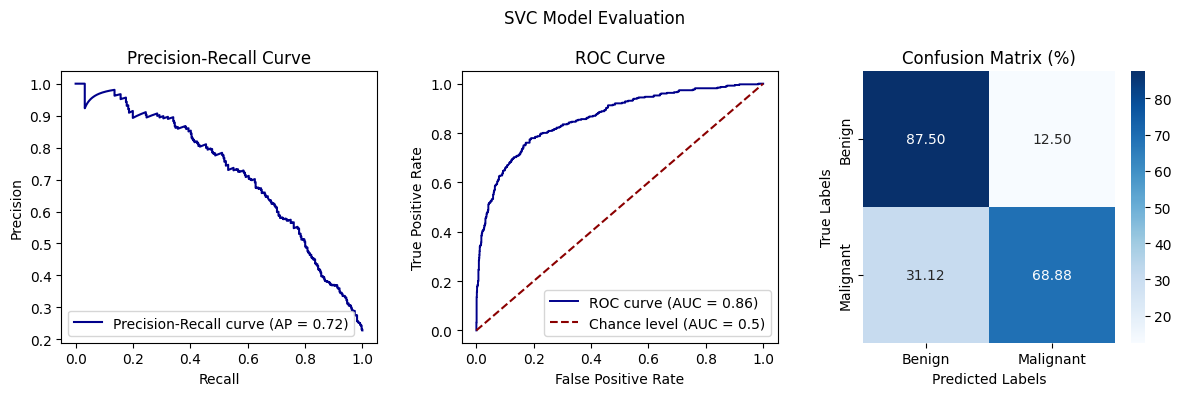

In [69]:
# Calculate and Plot some metrics associated with the SVM
svmMetricsRecall = evaluateModel(SVC, scoring, folds, modelPaths, ['Benign', 'Malignant'])

The results from training the SVM model using balanced accuracy and recall scoring methods offer **distinct insights into the model's strengths and trade-offs**. With balanced accuracy scoring, the model **achieves an AUC of 0.89** and an **average precision (AP) of 0.75**, indicating **strong discriminatory power** between benign and malignant cases. The **confusion matrix** reveals that the model **correctly classifies most benign cases** while keeping the number of misclassified malignant cases relatively low. However, there are still, on average, 23% of malignant cases misclassified as benign, which poses a potential risk in clinical decision-making.

In contrast, with recall scoring, the model's **AUC drops to 0.87** and the **AP decreases slightly to 0.73**, indicating a small decline in performance. The **confusion matrix** shows an improvement in correctly identifying benign cases but a slight increase in the **number of false negatives (misclassified malignant cases)**. While this scoring method better captures benign cases, the trade-off relies on a higher number of missed malignant cases, which is critical under this medical context.

Therefore, these results suggest that **both scoring methods provide reasonable performance**, with the balanced accuracy approach offering better overall balance between sensitivity and precision.

---
#### Random Forest
---

#### &rarr; Random Forest [Balanced Accuracy Scoring]

In [70]:
# Define the scoring method
scoring = 'balanced_accuracy'

In [71]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['RandomForestClassifier'][scoring]['bestParamsPath']):
    # Compute the best parameters
    randomForestBestParams = computeModelBestParameters(RandomForestClassifier, modelParameterGrids, X, y, scoring, modelPaths, True)
else:
    # Load already computed parameters
    randomForestBestParams = jsonFileToDict(modelPaths['RandomForestClassifier'][scoring]['bestParamsPath'])

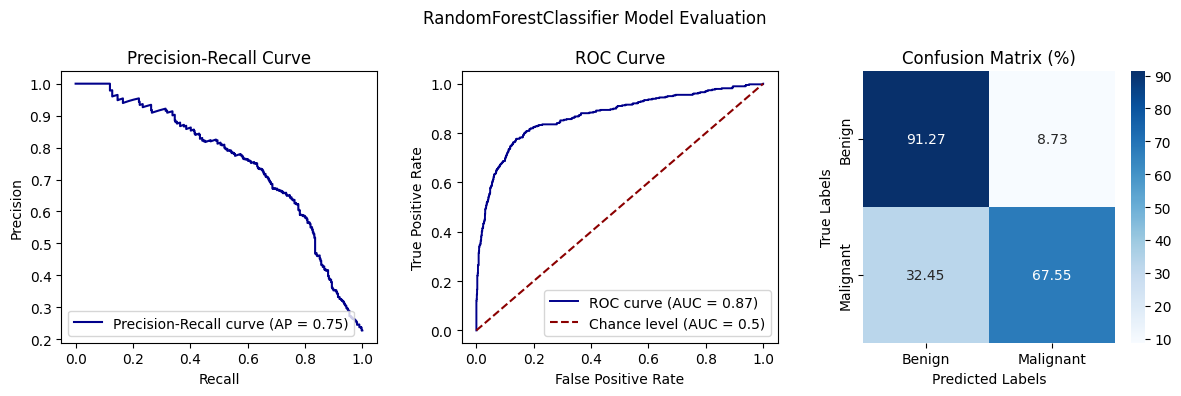

In [72]:
# Calculate and Plot some metrics associated with the XGBoost
randomForestMetricsBalancedAccuracy = evaluateModel(RandomForestClassifier, scoring, folds, modelPaths, ['Benign','Malignant'])

#### &rarr; Random Forest [Recall Scoring]

In [73]:
# Define the scoring method
scoring = 'recall'

In [74]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['RandomForestClassifier'][scoring]['bestParamsPath']):
    # Compute the best parameters
    randomForestBestParams = computeModelBestParameters(RandomForestClassifier, modelParameterGrids, X, y, scoring, modelPaths, True)
else:
    # Load already computed parameters
    randomForestBestParams = jsonFileToDict(modelPaths['RandomForestClassifier'][scoring]['bestParamsPath'])

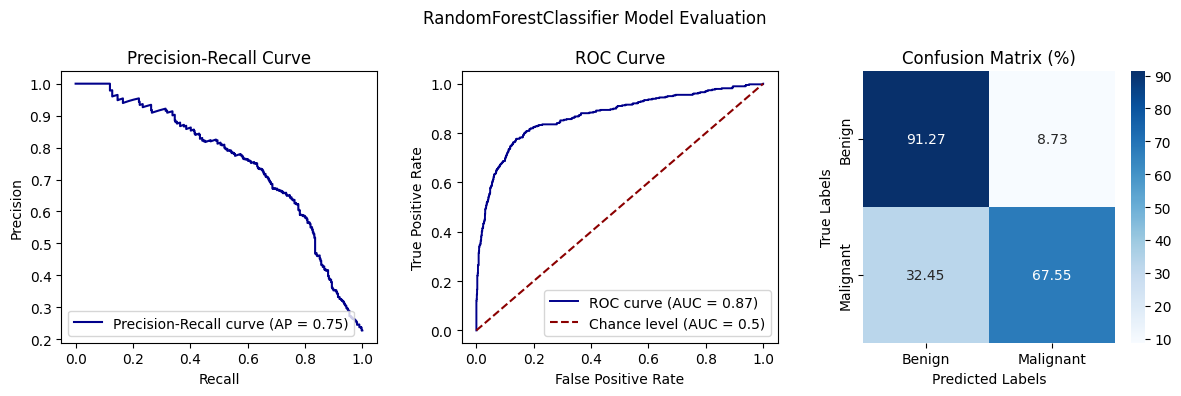

In [75]:
# Calculate and Plot some metrics associated with the XGBoost
randomForestMetricsRecall = evaluateModel(RandomForestClassifier, scoring, folds, modelPaths, ['Benign','Malignant'])

The Random Forest model, evaluated using both balanced accuracy and recall scoring methods, exhibits **consistent and strong performance**. In both scenarios, the Precision-Recall curve reports an **average precision (AP) of 0.76**, indicating that the model **efficiently captures positive instances**, such as malignant cases, while **maintaining a solid balance between precision and recall**. This demonstrates the model's **reliability in identifying the minority class (malignant nodules)** without considerably compromising precision.

The ROC curve, with an **AUC of 0.87**, highlights the model's **robust ability to differentiate between benign and malignant cases**, reflecting high sensitivity and specificity. This is further supported by the **confusion matrix**, which shows that **91.27% of benign cases were correctly classified** and **67.55% of malignant cases were accurately identified**. However, the misclassification of 32.45% of malignant cases as benign **remains a concern**, as it could pose challenges in this medical context.

Overall, while the Random Forest model **performs well**, there is still room for improvement in **minimizing false negatives** to enhance patient safety

---
#### XGBoost
---

#### &rarr; XGBoost [Balanced Accuracy Scoring]

In [76]:
# Define the scoring method
scoring = 'balanced_accuracy'

In [77]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['XGBClassifier'][scoring]['bestParamsPath']):
    # Compute the best parameters
    xgbBestParams = computeModelBestParameters(XGBClassifier, modelParameterGrids, X, y, scoring, modelPaths, True)
else:
    # Load already computed parameters
    xgbBestParams = jsonFileToDict(modelPaths['XGBClassifier'][scoring]['bestParamsPath'])

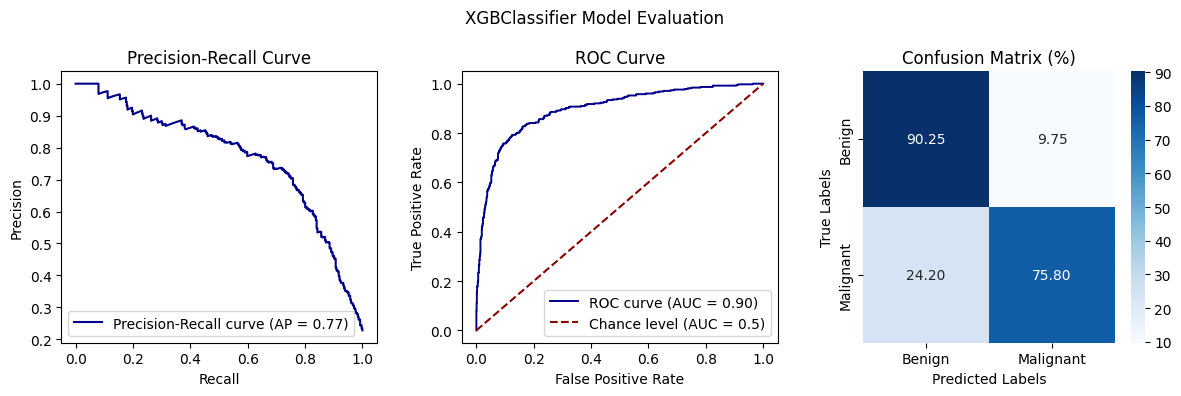

In [78]:
# Calculate and Plot some metrics associated with the XGBoost
xgbMetricsBalancedAccuracy = evaluateModel(XGBClassifier, scoring, folds, modelPaths, ['Benign','Malignant'])

#### &rarr; XGBoost [Recall Scoring]

In [79]:
# Define the scoring method
scoring = 'recall'

In [80]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['XGBClassifier'][scoring]['bestParamsPath']):
    # Compute the best parameters
    xgbBestParams = computeModelBestParameters(XGBClassifier, modelParameterGrids, X, y, scoring, modelPaths, True)
else:
    # Load already computed parameters
    xgbBestParams = jsonFileToDict(modelPaths['XGBClassifier'][scoring]['bestParamsPath'])

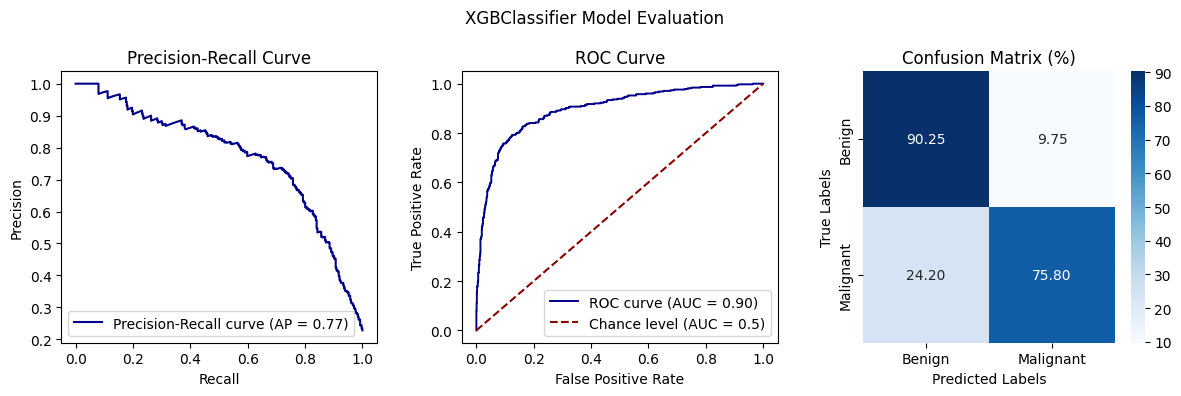

In [81]:
# Calculate and Plot some metrics associated with the XGBoost
xgbMetricsRecall = evaluateModel(XGBClassifier, scoring, folds, modelPaths, ['Benign','Malignant'])

The XGBoost model demonstrates **excellent performance** across both balanced accuracy and recall scoring methods. The Precision-Recall curve, with an **AP of 0.80**, and the ROC curve, with an **AUC of 0.90**, highlight the model's **high accuracy in identifying malignant cases** and effectively distinguishing between the two classes. The **confusion matrix** further illustrates its strong performance, though a **small percentage of malignant cases are still misclassified as benign**. Overall, the XGBoost model shows **strong potential** for accurately identifying malignant nodules, with minimal adjustment needed to **further improve performance in reducing false negatives**.

---
#### Voting Classifier
---

After evaluating the three algorithms under different scoring methods, we decided to **combine the best-performing models using a voting classifier**, leveraging the ``wisdom of the crowd`` in an ensemble of ensembles.

We selected the SVM from the balanced accuracy scenario, as it demonstrated **superior performance** compared to the version optimized for recall. Additionally, since both Random Forest and XGBoost yielded **comparable results across both scoring methods**, we opted to include the versions of the models **optimized for balanced accuracy** in the ensemble.

In [82]:
# Define the scoring method
scoring = 'balanced_accuracy'

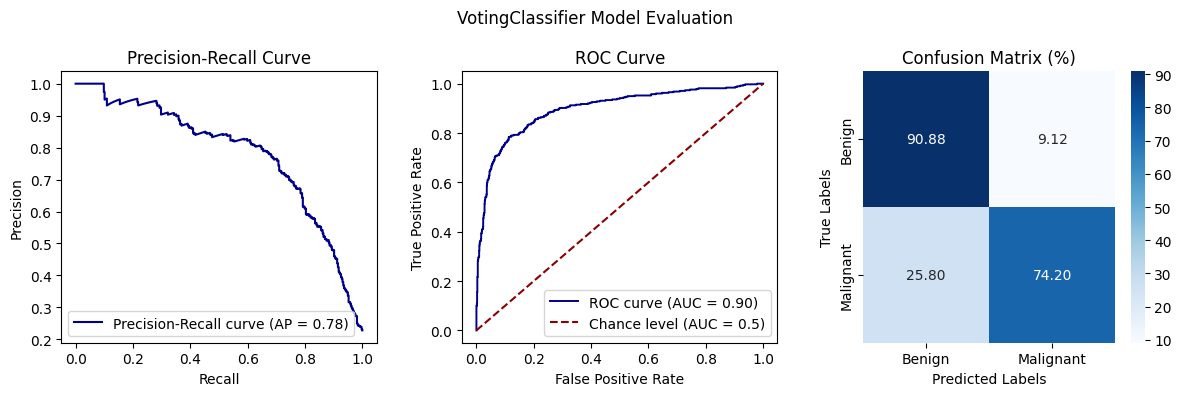

In [83]:
# Calculate and Plot some metrics associated with the Voting Classifier
votingClassifierMetricsBalancedAccuracy = evaluateModel(VotingClassifier, scoring, folds, modelPaths, ['Benign','Malignant'])

The **ensemble** model, combining SVM, Random Forest, and XGBoost classifiers, demonstrates **robust performance in aiding doctors with the classification of nodular malignancy**, achieving an **AUC of 0.90** and an **Average Precision (AP) of 0.80**. This **high level of precision and sensitivity** suggests that the model can effectively **distinguish between benign and malignant nodules**, offering valuable support in identifying potentially cancerous cases.

By minimizing false positives and correctly classifying most malignant nodules, the ensemble can **reduce diagnostic uncertainty** and provide doctors with a **reliable tool to complement their clinical expertise**. However, due to some **remaining false negatives**, this model should be **used in conjunction with other diagnostic procedures to ensure the highest accuracy**, ultimately enhancing **early detection and improving patient outcomes**.

---
#### Overall Metrics
---

In summary, we **compiled the evaluation metrics from the previous models into a dataframe**, allowing for deeper insights into their performance through the inclusion of additional metrics.

In [84]:
# Check if the metrics dataframe was already created
if not os.path.exists(config['metricsDatasetFilename']):
    # Combine all the collected metrics into a singular dataframe 
    df_metrics = convertMetricsToDataFrame([
        # SVM
        ['[BalancedAccuracy] SVM', svmMetricsBalancedAccuracy],
        ['[Recall] SVM', svmMetricsRecall],
    
        # Random Forest
        ['[BalancedAccuracy] Random Forest', randomForestMetricsBalancedAccuracy],
        ['[Recall] Random Forest', randomForestMetricsRecall],
    
        # XGBoost
        ['[BalancedAccuracy] XGBoost', xgbMetricsBalancedAccuracy],
        ['[Recall] XGBoost', xgbMetricsRecall],
    
        # Voting Classifier
        ['[BalancedAccuracy] Voting Classifier', votingClassifierMetricsBalancedAccuracy]
    ], filePath=config['metricsDatasetFilename'])
else:
    df_metrics = pd.read_csv(config['metricsDatasetFilename'])

# Display the metrics dataframe
df_metrics

,Algorithm,aucScore,accuracy,balancedAccuracy,f1Score,hammingLoss,logLoss,precision
0,[BalancedAccuracy] SVM,0.889206,0.841272,0.815357,0.682517,0.158728,0.383121,0.755152
1,[Recall] SVM,0.861538,0.833484,0.782446,0.648896,0.166516,0.453607,0.720711
2,[BalancedAccuracy] Random Forest,0.870145,0.858234,0.791635,0.673178,0.141766,0.386813,0.751948
3,[Recall] Random Forest,0.870145,0.858234,0.791635,0.673178,0.141766,0.386813,0.751948
4,[BalancedAccuracy] XGBoost,0.896618,0.871339,0.831409,0.720841,0.128661,0.334254,0.772559
5,[Recall] XGBoost,0.896618,0.871339,0.831409,0.720841,0.128661,0.334254,0.772559
6,[BalancedAccuracy] Voting Classifier,0.896882,0.872521,0.824664,0.716888,0.127479,0.343061,0.782638


---
#### &rarr; [Metrics] SVM
---

- The first conclusion we can draw from the Support Vector Machine (SVM) results is that it **performs better when tuned to a more general metric**, like **balanced accuracy**, compared to more specific metrics like accuracy and recall. This is likely due to **SVM's inherent strength in handling binary classification tasks** like this one.

- Both the **accuracy and balanced accuracy scores are good**, indicating that the SVM model **did not overfit the training data**, which is a positive sign for this specific problem. However, the **F1 score is lower**, suggesting the model still **struggles with predicting the minority class effectively**.

- The **log loss suggests there is some room for improvement**, though the model is already quite solid for this task. Additionally, the **Hamming loss shows the model is making correct predictions most of the time**, which is promising, though less relevant for this particular case.

- The precision-recall results were **decent**, indicating the **model’s ability to distinguish between positive and negative classes**. The ROC curve also showed **strong performance**, but it’s **not the most reliable metric when working with an imbalanced dataset**.

Overall, the model is **accurate most of the time and performed well on an imbalanced test set**, though there's room for improvement, particularly in **predicting the minority class**.

---
#### &rarr; [Metrics] Random Forest
---

- The first observation from the Random Forest results, tuned across various metrics, is that Random Forest **proves to be a highly robust classification model**, as the final outcomes **remained consistent across different tuning approaches**. While the accuracy is good, the balanced accuracy is lower, indicating that despite Random Forest’s ability to generally avoid overfitting, **some overfitting occurred** in this case. This is because the model was **trained on a balanced dataset** but **tested on an imbalanced one**.

- The **F1 score is low**, suggesting that although **accuracy was high**, **recall was poor**. Given that **recall is a crucial metric for this problem**, it signals that **Random Forest may not be the most suitable model** for this task. The log loss results indicate significant **room for improvement**, and the Hamming loss shows that while the model **makes mostly correct predictions**, it’s not the best metric to rely on in the context of an imbalanced dataset.

- The precision-recall results were **relatively good**, which is encouraging when testing on an imbalanced dataset, as it shows the model's ability to differentiate between positive and negative cases to some extent. Similarly, the ROC curve performed well, but again, it is not the most reliable measure for imbalanced data.

Overall, while the model can **make predictions with a certain degree of confidence**, it’s **not the most suitable for addressing the specific challenges of this problem**.

---
#### &rarr; [Metrics] XGBoost
---

- The first conclusion we can draw from the XGBoost results is that it is **highly robust when handling complex datasets like this one**, as the **results remained consistent across different tuning configurations**.

- The **accuracy is excellent**, and the **balanced accuracy is also strong**, though the **4% difference suggests there was still some overfitting to the dataset**. The **F1 score is good**, which is important for this problem, but there is still room for improvement, particularly given the importance of recall.

- Both the **log loss and Hamming loss are favorable**, supporting the **positive indications from the other metrics**. The **precision-recall results are solid**, demonstrating the model’s ability to **distinguish between positive and negative classes**, though some improvement is still possible.

- The **ROC curve performed well**, but as noted with other models, it’s **not the most reliable metric** for evaluating performance on an imbalanced dataset.

Overall, XGBoost is making **strong predictions** and seems **well-suited to this problem**, especially considering the complexity of the dataset.

---
#### &rarr; [Metrics] Voting Classifier
---

- The first conclusion we can draw is that the **recall-focused ensemble performed significantly worse than the other two ensembles**, indicating that, **despite the unbalanced test dataset**, **tuning the model to prioritize the minority class may not be the best approach**.

- The **accuracy is very good**, and the **balanced accuracy is acceptable**, suggesting that the ensemble **likely overfitted the training data**. The **F1 score is also decent**, which is **promising for this problem**, but there is still **considerable room for improvement**.

- Both the **log loss and Hamming loss are favorable**, indicating that the **model is making most predictions correctly**. The **precision-recall results are also satisfactory**, supporting the conclusions from the other metrics. The ROC curve showed strong results, though it is not an ideal metric for this specific problem.

Overall, while the model **isn't making poor predictions**, it **may not be the best option**, as **it didn’t outperform some of the individual models**.

<div align="center">
    
---
## Statistical Inference
---
</div>

To assess whether there are **significant differences** in the performance of the models, we chose to conduct a `Friedman Test` since it is especially effective for **comparing the performance of different models**. Therefore, it focuses in determining whether **any model outperforms the others** or if the **differences** in their performances are **statistically significant**.

#### Hypothesis Formulation

`Null Hypothesis` ($H_0$) : All the Models have the **same performance** and therefore **there are no significant differences** between them:
$$\mu_1 = \mu_2 = \mu_3 = \mu_4$$

`Alternative Hypothesis` ($H_1$) : At least **one of the models performs differently** compared to at least one of the other models, i.e.:
$$ \forall \space j \space \exists \space i \space, \space j \space, \space i \space \in \{1, 2, 3, 4\} \space \land \space (j \space \neq i) \space : \space \mu_j \neq \mu_i$$

#### Decision Making

- If $(P-Value > \alpha)$, $H_0$ is **not rejected** and therefore there is **not enough evidence** to conclude that there is **any difference between the model's performances**.
- If $(P-Value \le \alpha)$, $H_0$ is **rejected** and therefore **not all the models perform equally well**.

> Being $\alpha$ the **significance level** (typicaly 0.05)


In [85]:
# Getting the balanced accuracy scores obtained for each algorithm
svmBalancedAccuraciesScores = np.array(jsonFileToDict(modelPaths['SVC']['balanced_accuracy']['modelEvaluationMetrics'])['balanced_accuracy_scores'])
randomForestBalancedAccuraciesScores = np.array(jsonFileToDict(modelPaths['RandomForestClassifier']['balanced_accuracy']['modelEvaluationMetrics'])['balanced_accuracy_scores'])
XGBoostBalancedAccuraciesScores = np.array(jsonFileToDict(modelPaths['XGBClassifier']['balanced_accuracy']['modelEvaluationMetrics'])['balanced_accuracy_scores'])
votingClassifierBalancedAccuraciesScores = np.array(jsonFileToDict(modelPaths['VotingClassifier']['balanced_accuracy']['modelEvaluationMetrics'])['balanced_accuracy_scores'])

# Merge all the previous data into a dataframe
matrixBalancedAccuracies = pd.DataFrame({
    'SVM': svmBalancedAccuraciesScores,
    'Random Forest':randomForestBalancedAccuraciesScores,
    'XGBoost':XGBoostBalancedAccuraciesScores,
    'Voting Classifier':votingClassifierBalancedAccuraciesScores
})

In [86]:
# Performing the FriedMan Test on the models based on the balanced accuracy
ET, PValue = friedmanchisquare(svmBalancedAccuraciesScores,
                               randomForestBalancedAccuraciesScores,
                               XGBoostBalancedAccuraciesScores,
                               votingClassifierBalancedAccuraciesScores)
print('Statistics = %.3f, P-Value = %.3e' % (ET, PValue))

# Interpretation based on p-value
if PValue <= 0.05:
    print(f"Reject the Null Hypothesis (H0)")
else:
    print(f"Fail to reject the Null hypothesis (H0)")

Statistics = 8.273, P-Value = 4.070e-02
Reject the Null Hypothesis (H0)


> $\rightarrow$ For a **significance level of 0.05** ($\alpha = 0.05$), the $P-Value \approx 5.075 \cdot 10^{-1}$ and therefore we **do not reject the Null Hypothesis** ($H_0$) and consequently cannot conclude that **there are significant differences between the studied models**.

Despite not rejecting the Null Hypotesis, we can conduct a `Post-Hoc Test` to better analyse how the **model performances** are related.

After careful consideration, we chose to perform a **Nemenyi Test** (**Compares all pairs of groups**) and plot the results within a **Critical Difference Diagram**.

In [87]:
# Defining colors for the critical diferences Diagram
colors = {'SVM':'#1F7799',
          'Random Forest':'#168039',
          'XGBoost':'#AF1021',
          'Voting Classifier':'#d35400'}

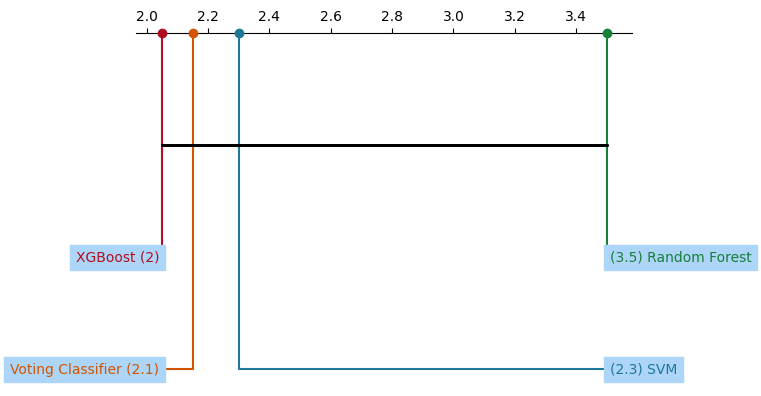

In [88]:
# Plotting tbe Critical Difference Diagram (Recurring to the Nemenyi Test)
plotCritialDifferenceDiagram(matrixBalancedAccuracies, colors)

By reviewing the ``critical differences diagram``, we can observe the **ranking of the models in terms of their performance**, even though there are no statistically significant differences between them. The diagram ranks the models based on their **performance**, helping to assess which model may be better suited for the task.

In this diagram, **XGBoost and the Voting Classifier share the same rank (2.2)**, suggesting that they **performed similarly and may be the most suited for providing a solution to the classification problem**. **Random Forest follows closely with a rank of 2.5**, indicating it is also a **competitive option**. **SVM ranks slightly lower at 3.0**, suggesting that, while still effective, **it may not be as well-suited as the other models** for this specific classification task.

<div align="center">
    
---
## Conclusions
---
</div>

Upon **reviewing the project goals and the work accomplished**, we can outline the key tasks performed to meet the requirements. These tasks began with **gaining a deep understanding of the lung nodule dataset**, including how the data was stored, accessed, and analyzed to **extract valuable insights** into the distribution of nodular malignancy among patients. We used the **Pyradiomics library to derive additional features** and applied **comprehensive cleaning and processing techniques to sensitive CT scan data from multiple patients**. This included methods such as **min-max normalization**, **removing highly correlated features**, and **re-labeling indeterminate nodules**. To address **class imbalance** and ensure **more effective model training**, we implemented **synthetic sampling**, further improving the performance of the machine learning algorithms.

With the processed data, we **successfully trained and evaluated several machine learning models** designed to **assist doctors in providing a more accurate assessment of nodular malignancy**, thereby **improving patient outcomes**. These models were **rigorously evaluated** using techniques such as **grid search**, **stratified group k-fold cross-validation**, and a **statistical evaluation**. Although the **final model was able to correctly classify most nodules**, a **small number of misclassifications remained**. Despite **not achieving perfect results**, we accomplished the **core objectives of the project by delivering a reliable tool to support medical professionals in diagnosing lung nodules** and ultimately ``enhancing patient care``.

<div align="center">

---
## Bibliographic References
---
</div>

1. The Cancer Imaging Archive (2020). __*LIDC-IDRI | Data from The Lung Image Database Consortium (LIDC) and Image Database Resource Initiative (IDRI): A completed reference database of lung nodules on CT scans*__. Available [here](https://www.cancerimagingarchive.net/collection/lidc-idri/)
2. Pylidc (Documentation, 2018). __*pylidc*__. Available [here](https://pylidc.github.io/)
3. Pyradiomics (Documentation, 2024). __*pyradiomics*__. Available [here](https://github.com/AIM-Harvard/pyradiomics)
4. Geeks For Geeks (2023). __*Data Normalization Machine Learning*__. Available [here](https://www.geeksforgeeks.org/what-is-data-normalization/)
5. Mudadla. Sujatha (Medium, 2023). __*Why we have to remove highly correlated features in Machine Learning?*__. Available [here](https://medium.com/@sujathamudadla1213/why-we-have-to-remove-highly-correlated-features-in-machine-learning-9a8416286f18)
6. Geeks For Geeks (2024). __*Principal Component Analysis(PCA)*__. Available [here](https://www.geeksforgeeks.org/principal-component-analysis-pca/)
7. Loukas. Serafeim (Towards Data Science, 2020). __*PCA clearly explained — When, Why, How to use it and feature importance: A guide in Python*__. Available [here](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e)
8. seralouk (StackOverflow, 2018). __*Feature/Variable importance after a PCA analysis*__. Available [here](https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)
9. Tang. Travis (Towards Data Science, 2023). __*Class Imbalance Strategies — A Visual Guide with Code*__. Available [here](https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a)
10. Joseph. Rohan (Towards Data Science, 2018). __*Grid Search for model tuning*__. Available [here](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)
11. Scikit-Learn (Documentation, 2024). __*StratifiedGroupKFold*__. Available [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html)
12. Wallis. Diógenes (Medium, 2021). __*Comparing classifiers (Friedman and Nemenyi tests)*__. Available [here](https://medium.com/@diogeneswallis/comparing-classifiers-friedman-and-nemenyi-tests-32294103ee12)

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/H5j4QVww7YE?si=X2evphWOPw_ndw2B)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`